#### Consider Outliers
Many time series start off with some form of irregularity which could throw us off - TODO
#### Consider Normalising
We are *probably* not interested in absolute heart rate, or voltage levels.
So these can be normalised to make them easier to work on
#### Classes are humanly understandable
There are 4 classes:
 - (0) healthy
 - (1) arythmia1 (qualitatively?)
 - (2) arythmia2 (qualitatively?)
 - (3) noisy

#### Start with very simple features
- Look at K timestamp intervals 
- Try averaging between heartbeat windows 

#### Class imbalance
 Training set counts for the 4 classes are respectively [3030 443 1474 170]
 
#### Manual Feature extraction
- RR interval - DONE
- R amplitude - DONE
- Q amplitude - DONE
- QRS duration - DONE
- Heart rate variability - DONE
- Wavelet energy - TODO

#### consider using inter-qualtile ranges instead of variance 

##### Print Progress

`[(not i%100 and print(i)) or process(row) for i, row in table]`

In [1]:
backed_up = False

In [2]:
import csv
import numpy as np
from scipy.stats import iqr
import pandas as pd
from my_utils import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 7)
#plt.style.use('dark_background')

In [3]:
freq = 300.

In [4]:
# returns a dict mapping sample id [int] to the raw time series [np.array]
def importTimeSeries(filename):
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile)
    out = dict()
    first = True
    for row in datareader:
        if first:
            first = False
            continue
        out[int(row[0])] = np.asarray(row[1:], dtype=float)
    return out

X_train = importTimeSeries('X_train.csv')
X_test  = importTimeSeries('X_test.csv')
train = pd.read_csv('y_train.csv').set_index('id',drop=False)
test  = pd.read_csv('sample.csv').set_index('id',drop=False)
train['X'] = [X_train[k] for k in train.index.values]
test['X']  = [X_test[k]  for k in test.index.values]
n_train = len(train)
n_test  = len(test)
print(n_train)
print(n_test)

5117
3411


In [177]:
predicting = True # set to True when you come back here after fitting the Model
# this is ugly but yeah it's 2 am
if predicting:
    if not backed_up: 
        train_bk = train.copy()
        backed_up = True
        train = test
        n_train = n_test
else:
    if backed_up:
        train = train_bk
        n_train = len(train)
        backed_up = False

In [178]:
from biosppy.signals import ecg
train['ecg'] = [ecg.ecg(signal=x, sampling_rate=freq, show=False) for x in train.X]

In [179]:
train['dur'] = [len(x) for x in train.X]

In [180]:
# Unpack the ecg tuple into the dataframe
for field in train.ecg[0].keys():
    train[field] = [e[field] for e in train.ecg]
train['int_rpeaks'] = train.rpeaks
train = train.drop(['rpeaks'],axis=1)
print(train.columns.values)

['id' 'y' 'X' 'ecg' 'dur' 'ts' 'filtered' 'templates_ts' 'templates'
 'heart_rate_ts' 'heart_rate' 'int_rpeaks']


## Tedious hand crafting of features
You might want to remove some of the intervals before processing ...

In [181]:
# don't remember why we don't trust the default rpeaks...
train['rpeaks'] = [ecg.correct_rpeaks(signal=row.X, 
                                   rpeaks=row.int_rpeaks, 
                                   sampling_rate=freq, 
                                   tol=0.1)[0] for _,row in train.iterrows()] 

In [182]:
train['peaks'] = [row.X[row.rpeaks] for _,row in train.iterrows()] 

In [183]:
from biosppy.signals.tools import *

In [184]:
train['unfiltered_stats'] = [signal_stats(X) for X in train.X]
# Unpack the stats tuple into the dataframe
for field in train.unfiltered_stats[0].keys():
    train['unfiltered_'+field] = [stats[field] for stats in train.unfiltered_stats]

In [185]:
train['stats'] = [signal_stats(filt) for filt in train.filtered]
# Unpack the stats tuple into the dataframe
for field in train.stats[0].keys():
    train[field] = [stats[field] for stats in train.stats]

In [186]:
# Candidates for summarizing into a single template
train['avg_tempt'] = [np.mean(tempts, axis=0)   for tempts in train.templates]
train['med_tempt'] = [np.median(tempts, axis=0) for tempts in train.templates]
train['var_tempt'] = [np.var(tempts, axis=0)    for tempts in train.templates]
train['std_tempt'] = [np.std(tempts, axis=0)    for tempts in train.templates]
train['std_tempt_mean'] = [np.mean(x) for x in train.std_tempt]
train['std_tempt_std'] = [np.std(x) for x in train.std_tempt]
train['max_tempt'] = [np.max(tempts, axis=0)    for tempts in train.templates]
train['min_tempt'] = [np.min(tempts, axis=0)    for tempts in train.templates]
train['n_tempts']  = [np.shape(tempts)[0]    for tempts in train.templates]
# template timestamps are the same for all templates on all signals (-2 to +4 seconds)
templates_ts = train.loc[0].templates_ts

In [187]:
# stats from summarized templates
train['tempt_stats'] = [signal_stats(med) for med in train.med_tempt]
# Unpack the stats tuple into the dataframe
for field in train.tempt_stats[0].keys():
    train['tempt_'+field] = [stats[field] for stats in train.tempt_stats]
    
train['tempt_min'] = [np.min(med) for med in train.med_tempt]

In [188]:
missing_hr = [len(hr)==0 for hr in train.heart_rate]
print(train[missing_hr].id.values)
for id in train[missing_hr].index:
    train.at[id,'heart_rate'] = [0]
    train.at[id,'heart_rate_ts'] = [0]

[ 844 1279 2897]


In [189]:
unique_hr = [len(hr)==1 for hr in train.heart_rate]
print(train[unique_hr].id.values)
for id in train[unique_hr].index:
    hr = train.loc[id].heart_rate[0]
    train.at[id,'heart_rate'] = [hr,hr+0.0001]
    train.at[id,'heart_rate_ts'] = [0,0.0001]

[ 844 1279 2897]


In [190]:
couple_hr = [len(hr)==2 for hr in train.heart_rate]
print(train[couple_hr].id.values)
for id in train[couple_hr].index:
    hr = train.loc[id].heart_rate[1]
    train.at[id,'heart_rate']    = [hr,hr,hr+0.0001]
    train.at[id,'heart_rate_ts'] = [0, 0.0001 , 0.0002]

[ 532  844 1279 1789 2897]


In [191]:
train['hr_stats'] = [signal_stats(row.heart_rate) for i, row in train.iterrows()]
train['hr_min'] = [np.min(hr) for hr in train.heart_rate]

In [192]:
# Unpack the stats tuple into the dataframe
for field in train.hr_stats[0].keys():
    train['hr_'+field] = [stats[field] for stats in train.hr_stats]

In [193]:
train['heart_rate_diff'] = [np.diff(heart_rate) for heart_rate in train.heart_rate]
train['dhr_stats'] = [signal_stats(row.heart_rate_diff) for i, row in train.iterrows()]
train['dhr_min'] = [np.min(dhr) for dhr in train.heart_rate_diff]
# Unpack the stats tuple into the dataframe
for field in train.dhr_stats[0].keys():
    train['dhr_'+field] = [stats[field] for stats in train.dhr_stats]

In [194]:
# find that bloody sample with flat heart rate
bitches = train[train.hr_var==0].id.values
if len(bitches)==0: 
    print('bitches be gone')
else:
    print(bitches)
    bitch = bitches[0]
    temp = train.loc[bitch].heart_rate
    temp[0] += 0.0001 # wiggle the first sample
    train.at[bitch,'heart_rate'] = temp # and put it back
    train.at[bitch,'hr_stats'] = signal_stats(temp)

bitches be gone


In [195]:
train[np.isnan(train.hr_std_dev)]
# must be NaN free before you continue

,id,y,X,ecg,dur,ts,filtered,templates_ts,templates,heart_rate_ts,...,dhr_stats,dhr_min,dhr_mean,dhr_median,dhr_max,dhr_var,dhr_std_dev,dhr_abs_dev,dhr_kurtosis,dhr_skewness
id,,,,,,,,,,,,,,,,,,,,,


In [196]:
from scipy.stats.mstats import mquantiles

In [197]:
train['intervs']     = [np.diff(rpeaks)    for rpeaks  in train.rpeaks]
train['mean_interv'] = [np.mean(intervs)   for intervs in train.intervs]
train['var_interv']  = [np.var(intervs)    for intervs in train.intervs]
train['std_interv']  = [np.std(intervs)    for intervs in train.intervs]
train['med_interv']  = [np.median(intervs) for intervs in train.intervs]
train['min_interv']  = [np.min(intervs) for intervs in train.intervs]
train['max_interv']  = [np.max(intervs) for intervs in train.intervs]

In [198]:
train['iqr_interv']  = [iqr(intervs) for intervs in train.intervs]
train['q90_interv']  = [mquantiles(intervs,prob=0.9)[0] for intervs in train.intervs]
train['norm_q90_interv'] = train.q90_interv/train.med_interv
train['q10_interv']  = [mquantiles(intervs,prob=0.1)[0] for intervs in train.intervs]
train['norm_q10_interv'] = train.q10_interv/train.med_interv

In [199]:
train['q95_interv']  = [mquantiles(intervs,prob=0.95)[0] for intervs in train.intervs]
train['norm_q95_interv'] = train.q95_interv/train.med_interv
train['q05_interv']  = [mquantiles(intervs,prob=0.05)[0] for intervs in train.intervs]
train['norm_q05_interv'] = train.q05_interv/train.med_interv

In [200]:
from QRS_util import*
def findQS(signal):
    R_peaks, S_point, Q_point = EKG_QRS_detect(signal, freq, True, False)
def get_g_feats(templates):
    keys = [ 'numex',
         'varex',
         'S',
         'Q',
         #'R',
         'Sv',
         'Rv',
         'Qv',
         'numz',
         'tmprms',
         'tmpmean',
         'QZ',
         'SZ',
         'QS',
         'QZSZ']
    n_tempts = np.shape(templates)[0]
    g_features = {key: np.zeros(n_tempts) for key in keys}
    
    R = np.array([60])# R is always at sample 60 within the template

    for i in range(n_tempts):
        signal = templates[i]
        extrema, values = find_extrema(signal)
        g_features['numex'][i] = len(extrema)
        g_features['varex'][i] = np.var(values)
        g_features['tmprms'][i] = np.std(signal)
        g_features['tmpmean'][i] = np.mean(signal)

        S = find_S_point(signal, R)[0]
        Q = find_Q_point(signal, R)[0]

        g_features['S'][i] = S
        g_features['Q'][i] = Q
        #g_features['R'].append(R[0]) 

        zeros = zero_cross(signal)['zeros']
        g_features['numz'][i] = len(zeros)
        QZ = np.max(np.append(zeros[zeros<Q],0))
        SZ = np.min(np.append(zeros[zeros>S],179)) # 179 is last index in each template
        g_features['QZ']  [i] = QZ
        g_features['SZ']  [i] = SZ
        
        g_features['QS']  [i] = S-Q
        g_features['QZSZ'][i] = SZ-QZ  
        
        g_features['Sv']  [i] = signal[S]
        g_features['Rv']  [i] = signal[R]
        g_features['Qv']  [i] = signal[Q]  
        
    return g_features
from scipy.stats import kurtosis, skew
def get_g_stats(templates):
    g_features = get_g_feats(templates) 
    
    g_stats = dict()
    for key, values in g_features.items():
        npa_val = np.array(values)
        g_stats[key+'_var'] = np.var(npa_val)
        g_stats[key+'_med'] = np.median(npa_val)
        g_stats[key+'_mean'] = np.mean(npa_val)
        g_stats[key+'_iqr'] = iqr(npa_val)
        g_stats[key+'_kurt'] = kurtosis(npa_val)
        g_stats[key+'_skew'] = skew(npa_val)
        g_stats[key+'_q90'] = mquantiles(npa_val,prob=0.90)[0]
        g_stats[key+'_q95'] = mquantiles(npa_val,prob=0.95)[0]
        g_stats[key+'_q05'] = mquantiles(npa_val,prob=0.05)[0]
        g_stats[key+'_q10'] = mquantiles(npa_val,prob=0.10)[0]
        
    return g_stats

In [201]:
train['g_feats'] = [get_g_feats([tempt]) for tempt in train.med_tempt]
# Unpack the stats dict into the dataframe
for field in train.g_feats[0].keys():
    train['med_'+field] = [stats[field][0] for stats in train.g_feats]

In [202]:
train['g_stats'] = [get_g_stats(templates) for templates in train.templates]
# Unpack the stats dict into the dataframe
for field in train.g_stats[0].keys():
    train[field] = [stats[field] for stats in train.g_stats]

In [203]:
#noise as difference between before and after filtering
train['noise_avg'] = [np.sum(row.filtered-row.X)/row.dur for _,row in train.iterrows()]

In [204]:
train['noise_rms'] = [rms_error(row.filtered, row.X)[0] for _,row in train.iterrows()]
train['unfiltered_rms'] = [np.std(row.X) for _,row in train.iterrows()]
train['unfiltered_mean'] = [np.mean(row.X) for _,row in train.iterrows()]
train['unfiltered_iqr'] = [iqr(row.X) for _,row in train.iterrows()]
train['unfiltered_zeros'] = [len(zero_cross(row.X)['zeros']) for _,row in train.iterrows()]

In [205]:
train['unfiltered_extrema'] = [len(find_extrema(row.X)[0]) for _,row in train.iterrows()]

# wavelets

In [206]:
# not what I expected, probably won't even try them anymore

## END of manual feature extraction, this is what you got:

In [35]:
from pprint import pprint
pprint(train.columns.values.tolist())

['id',
 'y',
 'X',
 'ecg',
 'dur',
 'ts',
 'filtered',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate',
 'int_rpeaks',
 'rpeaks',
 'peaks',
 'unfiltered_stats',
 'unfiltered_mean',
 'unfiltered_median',
 'unfiltered_max',
 'unfiltered_var',
 'unfiltered_std_dev',
 'unfiltered_abs_dev',
 'unfiltered_kurtosis',
 'unfiltered_skewness',
 'stats',
 'mean',
 'median',
 'max',
 'var',
 'std_dev',
 'abs_dev',
 'kurtosis',
 'skewness',
 'avg_tempt',
 'med_tempt',
 'var_tempt',
 'std_tempt',
 'std_tempt_mean',
 'std_tempt_std',
 'max_tempt',
 'min_tempt',
 'n_tempts',
 'tempt_stats',
 'tempt_mean',
 'tempt_median',
 'tempt_max',
 'tempt_var',
 'tempt_std_dev',
 'tempt_abs_dev',
 'tempt_kurtosis',
 'tempt_skewness',
 'tempt_min',
 'hr_stats',
 'hr_min',
 'hr_mean',
 'hr_median',
 'hr_max',
 'hr_var',
 'hr_std_dev',
 'hr_abs_dev',
 'hr_kurtosis',
 'hr_skewness',
 'heart_rate_diff',
 'dhr_stats',
 'dhr_min',
 'dhr_mean',
 'dhr_median',
 'dhr_max',
 'dhr_var',
 'dhr_std_dev',
 'dhr_ab

## do some analysis

In [36]:
# USEFUL ANALYIS STUFF
def subsets():
    train0 = train[train.y==0]
    train1 = train[train.y==1]
    train2 = train[train.y==2]
    train3 = train[train.y==3]
    subs = [train0, train1, train2, train3]
    return subs

def randrow(i):
    if i==-1:
        return train.sample(1).iloc[0]
    else:
        return subsets()[i].sample(1).iloc[0]
    
def box(field):
    plt.boxplot([sub[field] for sub in subsets()], whis=[5, 95])
    plt.show()

In [37]:
subs = subsets()
counts = [len(s) for s in subs]
n0,n1,n2,n3 = counts
print(counts)

[3030, 443, 1474, 170]


In [38]:
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat, '\t',min(train[feat]),max(train[feat]))

id 	 0 5116
y 	 0 3
dur 	 2441 17813
unfiltered_mean 	 -218.097622478 185.589991435
unfiltered_median 	 -222.0 166.0
unfiltered_max 	 160.432067932 10532.1620902
unfiltered_var 	 486.909049275 1663423.59625
unfiltered_std_dev 	 22.0660157091 1289.73780136
unfiltered_abs_dev 	 94774.0 8365100.0
unfiltered_kurtosis 	 -0.698812309915 375.652062936
unfiltered_skewness 	 -16.946546125 15.3947707616
mean 	 -9.30680642829 8.09201219621
median 	 -39.6357285247 40.6384346608
max 	 34.682270363 6797.47444107
var 	 15.4162100267 516371.808903
std_dev 	 3.92634817951 718.590153636
abs_dev 	 17745.4456087 5076090.29879
kurtosis 	 0.623890602875 428.608551046
skewness 	 -13.3980363881 15.5071898398
std_tempt_mean 	 2.44036512129 954.474653156
std_tempt_std 	 0.908340113628 334.981526154
n_tempts 	 7 157
tempt_mean 	 -24.9240158555 137.185139031
tempt_median 	 -50.984720976 76.9228924469
tempt_max 	 4.37959682607 3032.13066756
tempt_var 	 1.57951711075 330329.951875
tempt_std_dev 	 1.25678841129 574.

In [39]:
print('Leaving out:')
for feat in train.columns:
    if not np.isscalar(train[feat][0]):
        print(feat, np.shape(train[feat][0]))

Leaving out:
X (16856,)
ecg (7,)
ts (16856,)
filtered (16856,)
templates_ts (180,)
templates (68, 180)
heart_rate_ts (67,)
heart_rate (67,)
int_rpeaks (68,)
rpeaks (68,)
peaks (68,)
unfiltered_stats (8,)
stats (8,)
avg_tempt (180,)
med_tempt (180,)
var_tempt (180,)
std_tempt (180,)
max_tempt (180,)
min_tempt (180,)
tempt_stats (8,)
hr_stats (8,)
heart_rate_diff (66,)
dhr_stats (8,)
intervs (67,)
g_feats ()
g_stats ()


id


/cluster/apps/python/3.6.1/x86_64/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


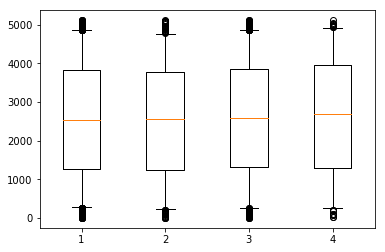

y


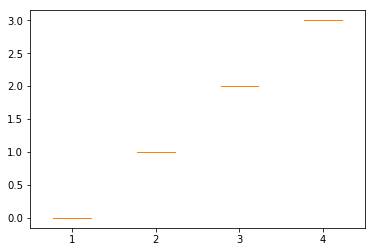

dur


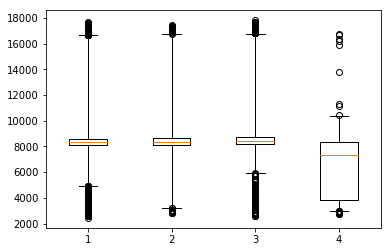

unfiltered_mean


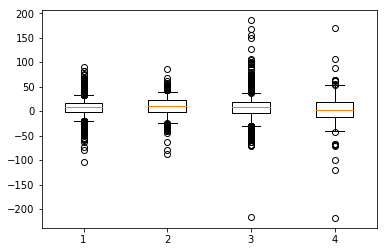

unfiltered_median


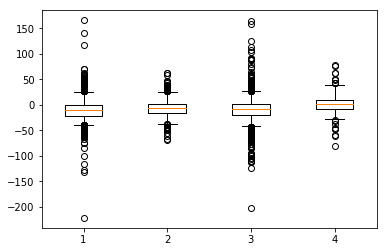

unfiltered_max


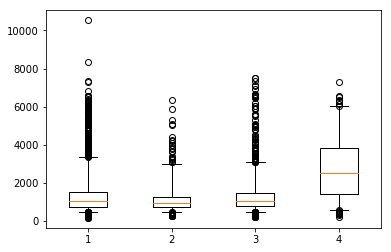

unfiltered_var


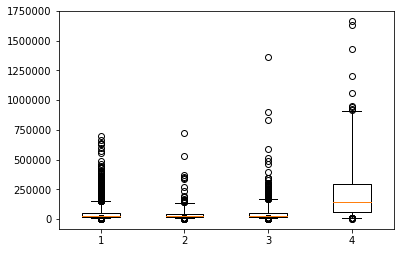

unfiltered_std_dev


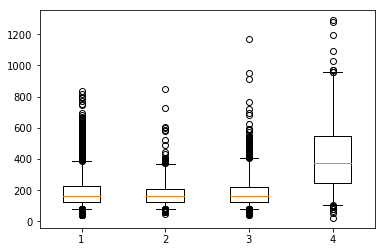

unfiltered_abs_dev


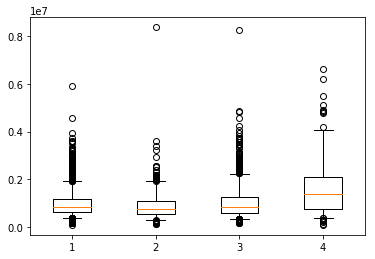

unfiltered_kurtosis


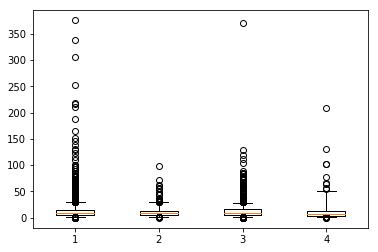

unfiltered_skewness


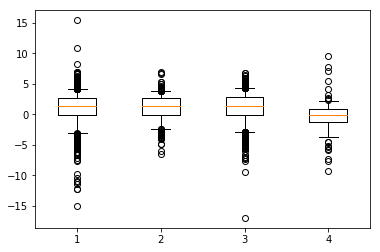

mean


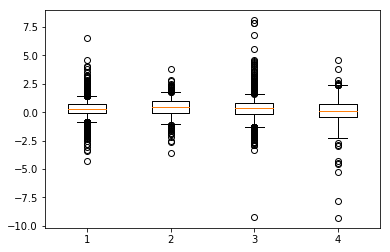

median


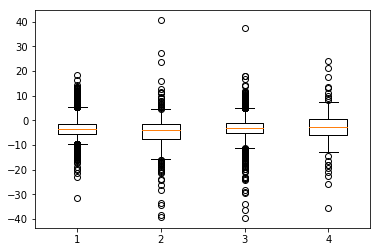

max


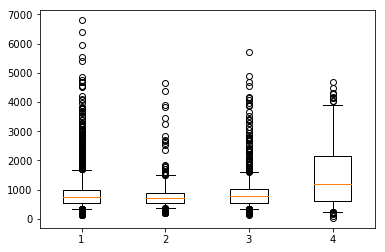

var


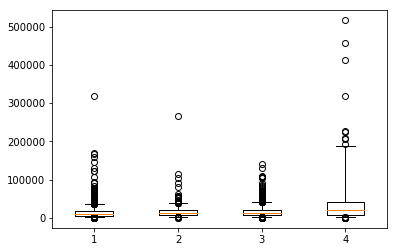

std_dev


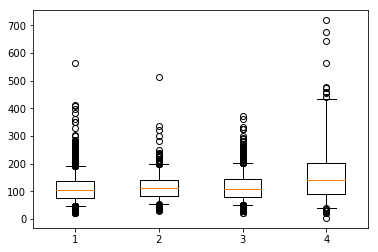

abs_dev


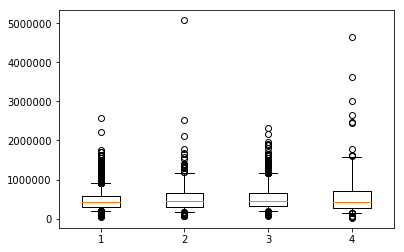

kurtosis


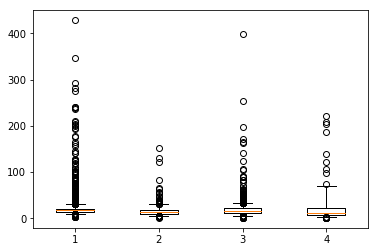

skewness


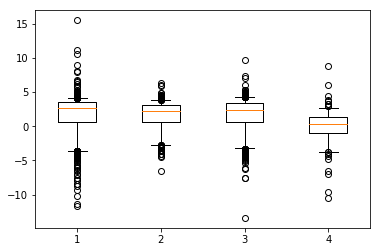

std_tempt_mean


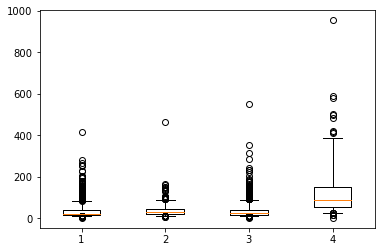

std_tempt_std


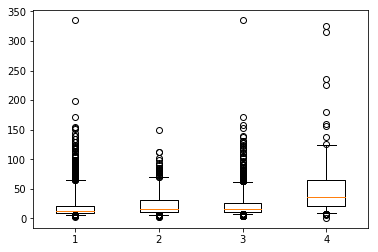

n_tempts


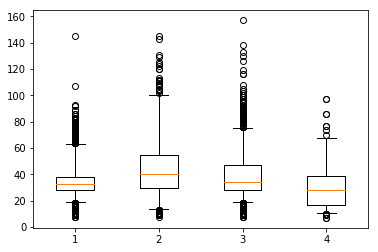

tempt_mean


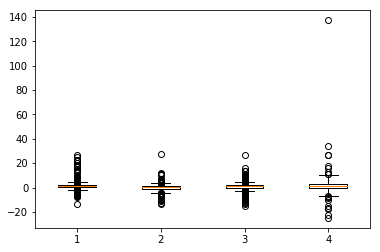

tempt_median


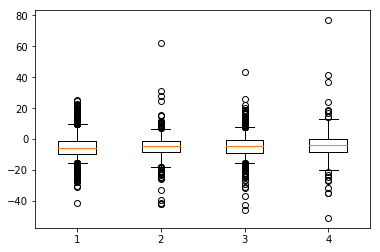

tempt_max


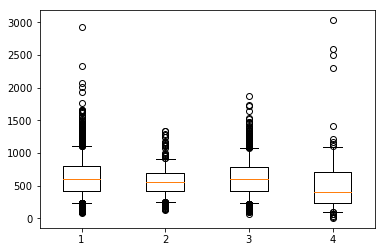

tempt_var


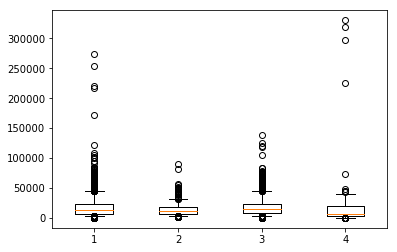

tempt_std_dev


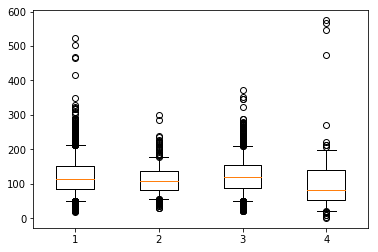

tempt_abs_dev


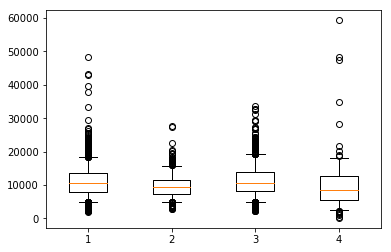

tempt_kurtosis


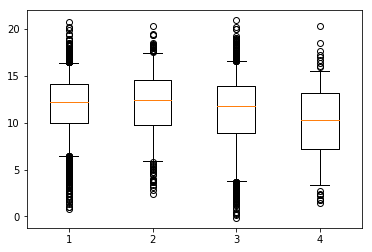

tempt_skewness


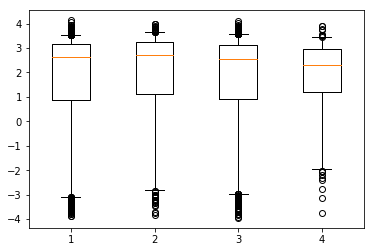

tempt_min


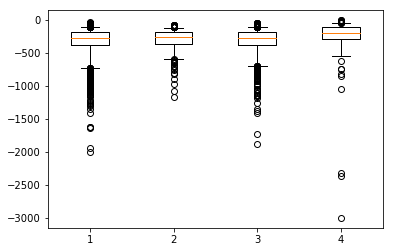

hr_min


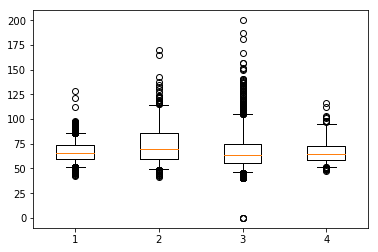

hr_mean


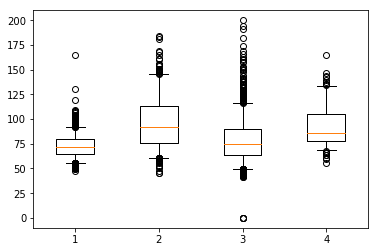

hr_median


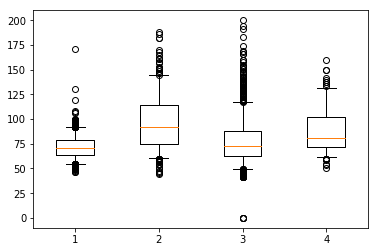

hr_max


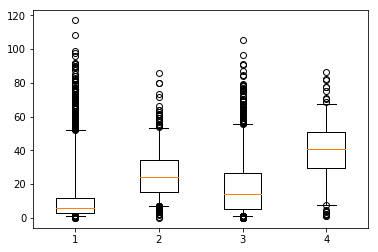

hr_var


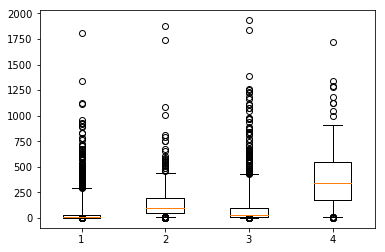

hr_std_dev


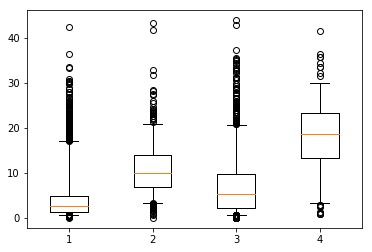

hr_abs_dev


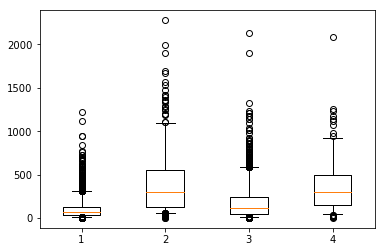

hr_kurtosis


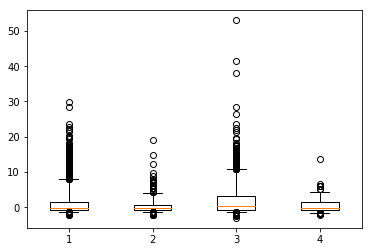

hr_skewness


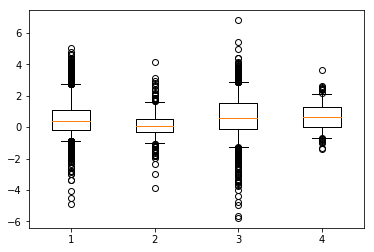

dhr_min


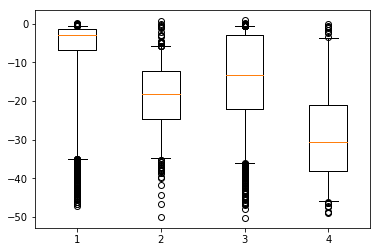

dhr_mean


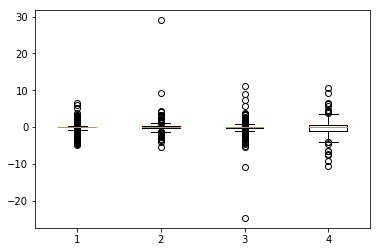

dhr_median


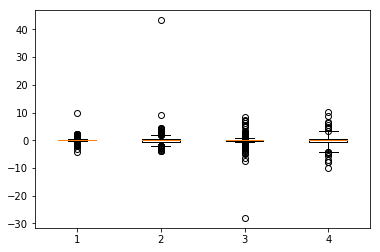

dhr_max


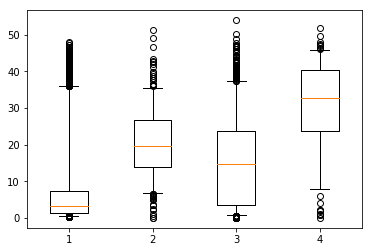

dhr_var


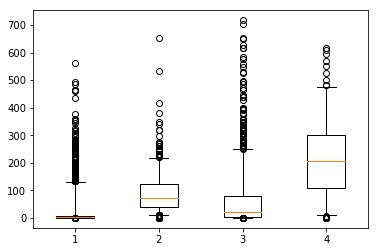

dhr_std_dev


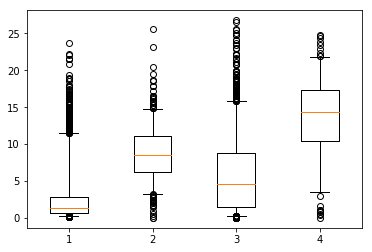

dhr_abs_dev


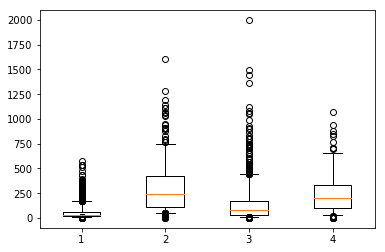

dhr_kurtosis


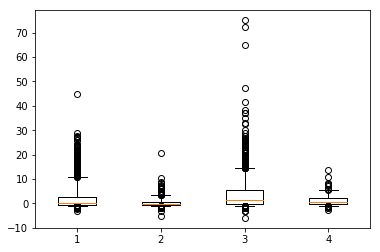

dhr_skewness


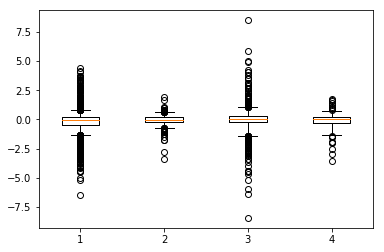

mean_interv


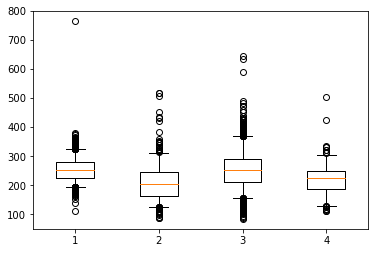

var_interv


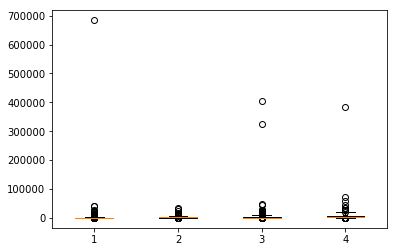

std_interv


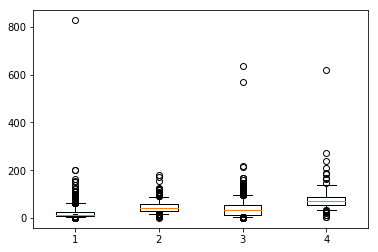

med_interv


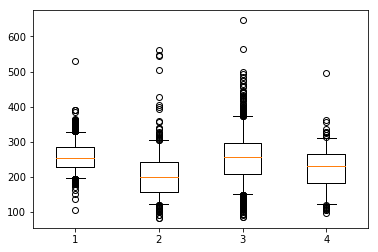

min_interv


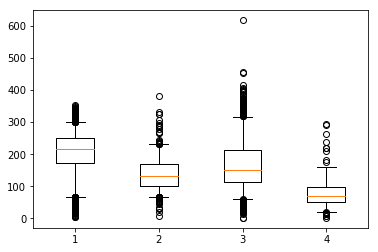

max_interv


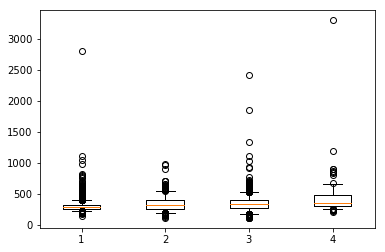

iqr_interv


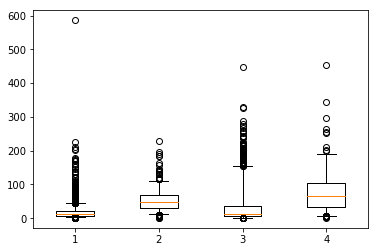

q90_interv


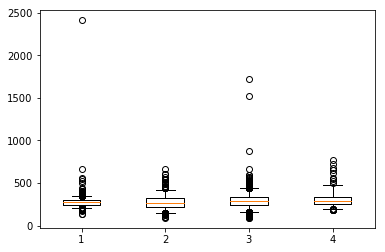

norm_q90_interv


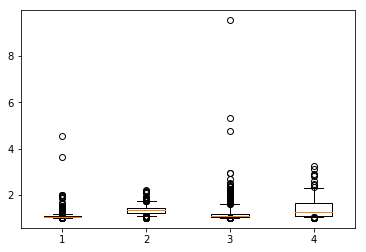

q10_interv


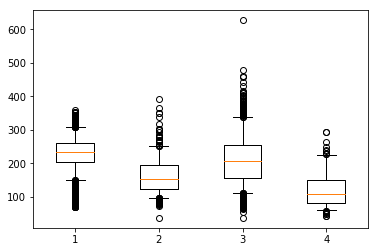

norm_q10_interv


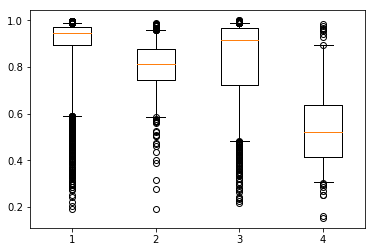

q95_interv


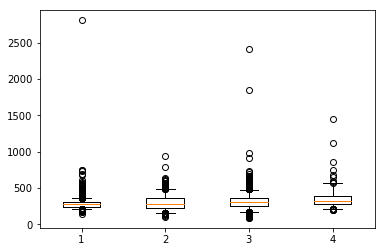

norm_q95_interv


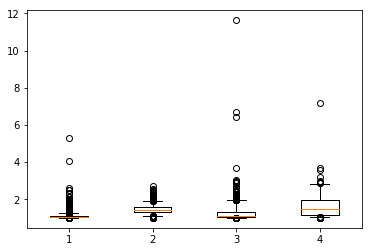

q05_interv


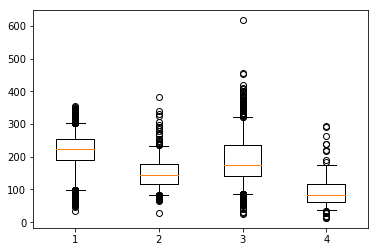

norm_q05_interv


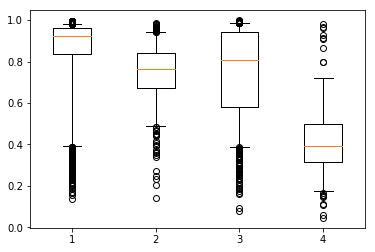

med_numex


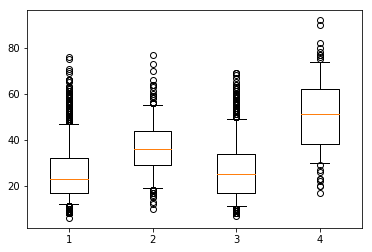

med_varex


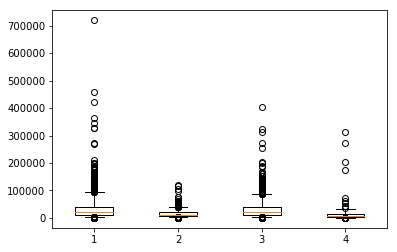

med_S


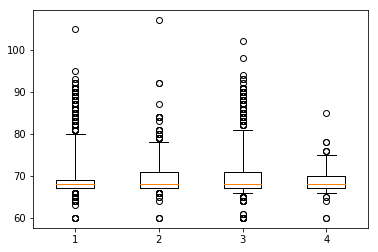

med_Q


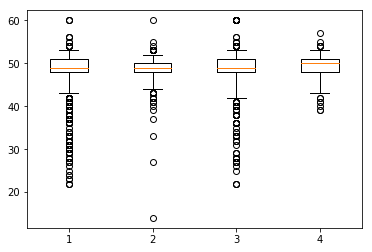

med_Sv


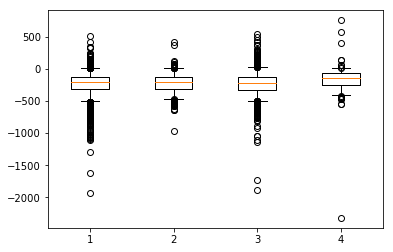

med_Rv


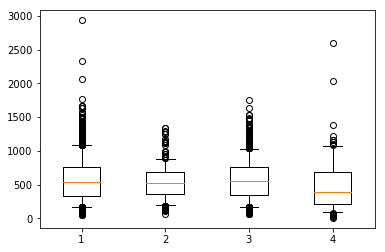

med_Qv


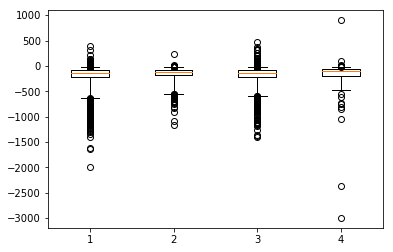

med_numz


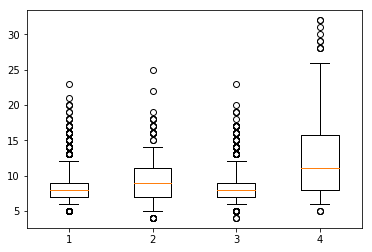

med_tmprms


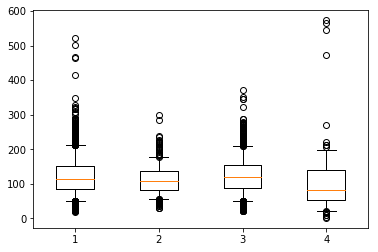

med_tmpmean


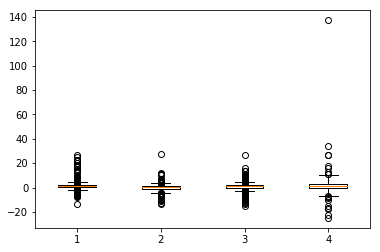

med_QZ


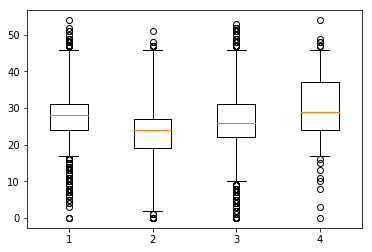

med_SZ


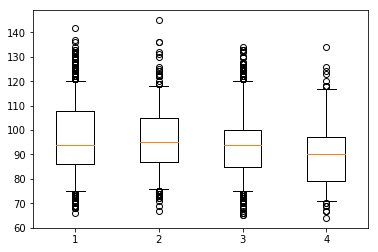

med_QS


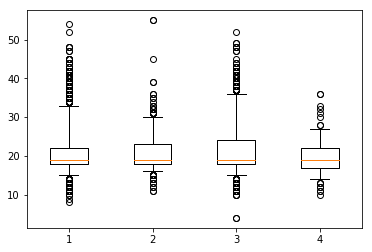

med_QZSZ


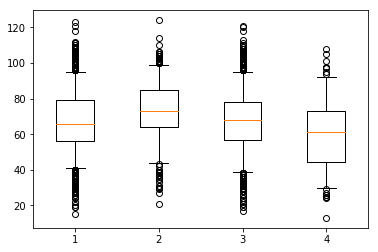

numex_var


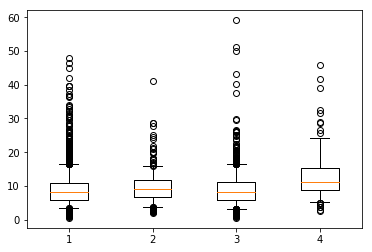

numex_med


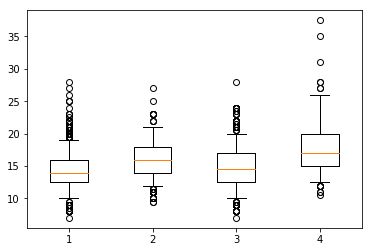

numex_mean


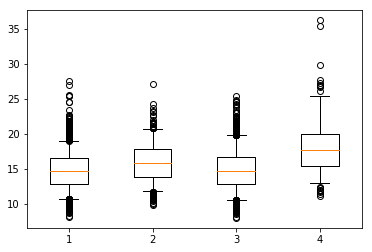

numex_iqr


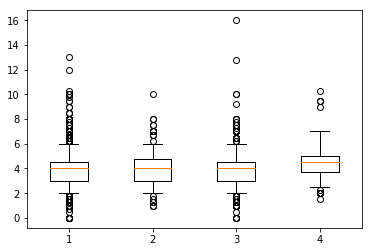

numex_kurt


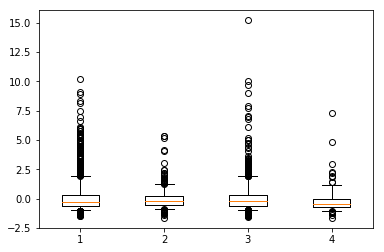

numex_skew


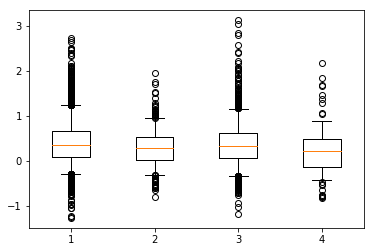

numex_q90


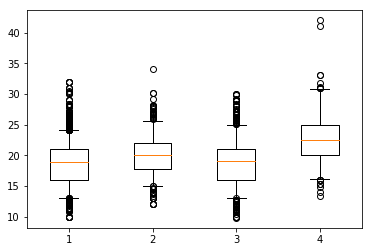

numex_q95


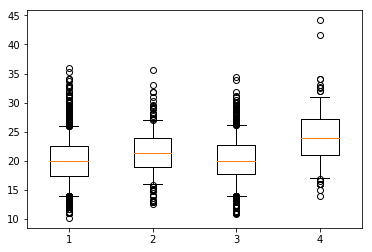

numex_q05


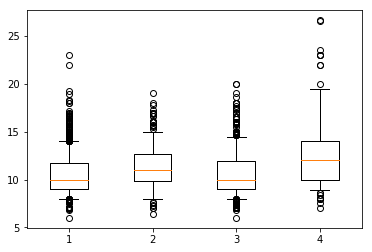

numex_q10


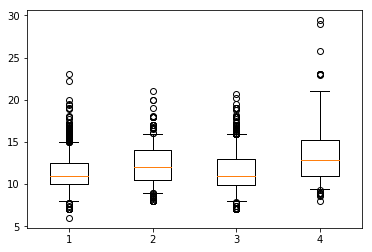

varex_var


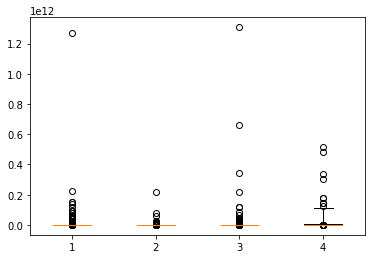

varex_med


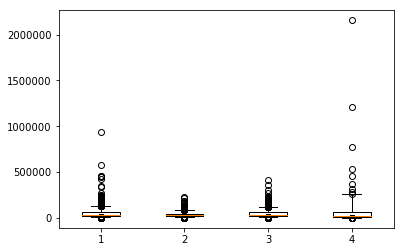

varex_mean


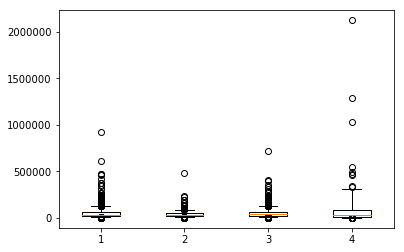

varex_iqr


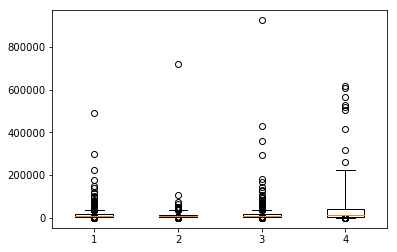

varex_kurt


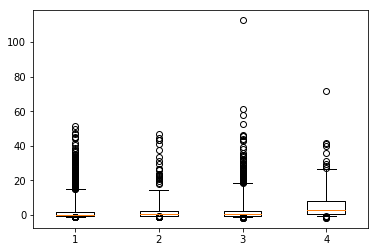

varex_skew


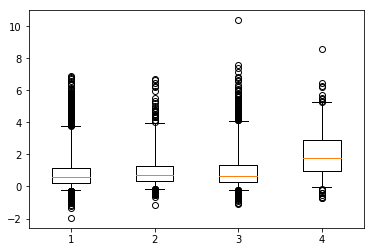

varex_q90


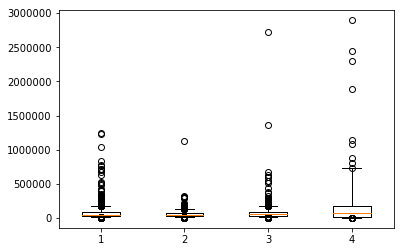

varex_q95


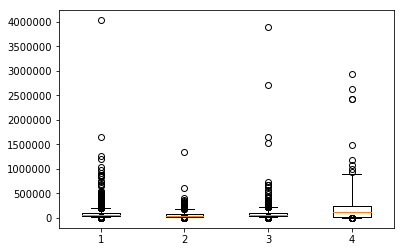

varex_q05


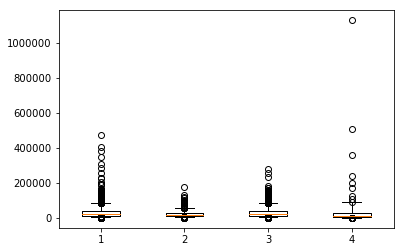

varex_q10


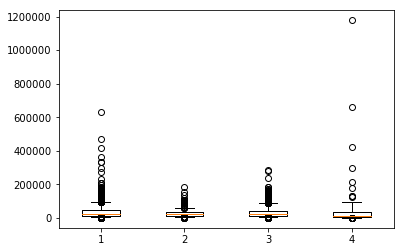

S_var


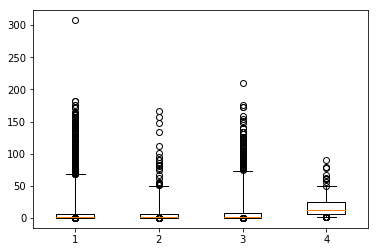

S_med


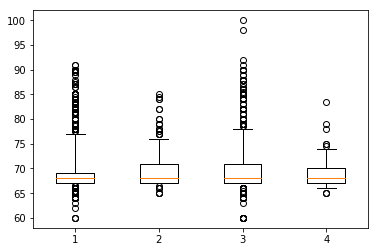

S_mean


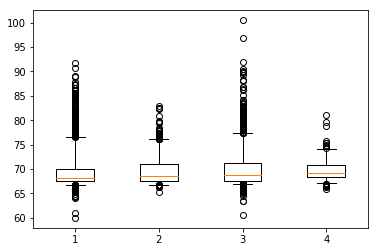

S_iqr


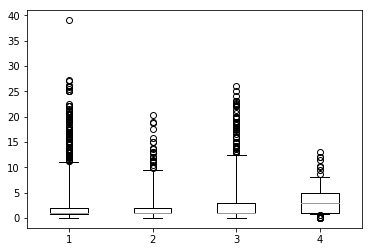

S_kurt


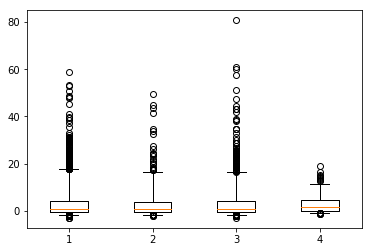

S_skew


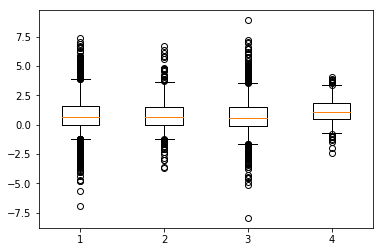

S_q90


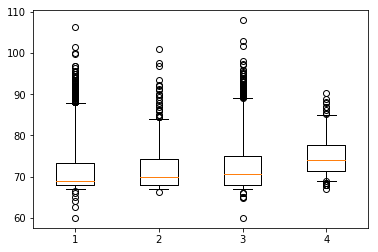

S_q95


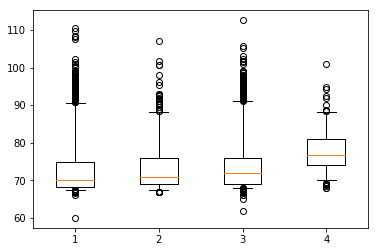

S_q05


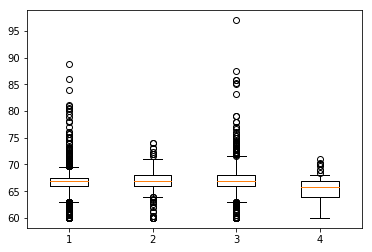

S_q10


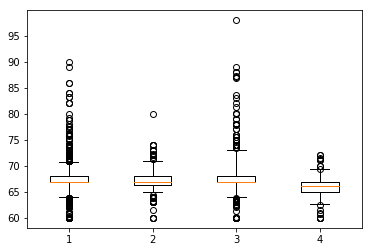

Q_var


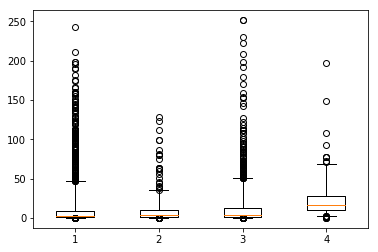

Q_med


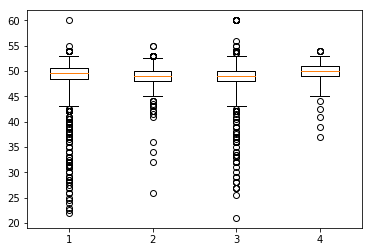

Q_mean


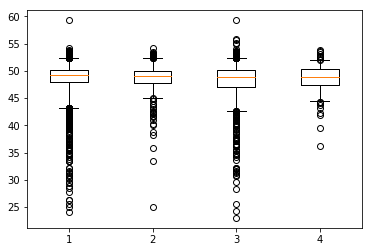

Q_iqr


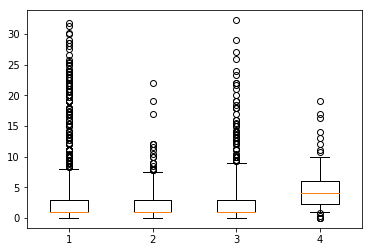

Q_kurt


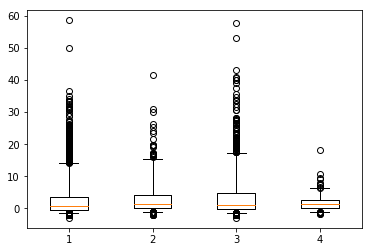

Q_skew


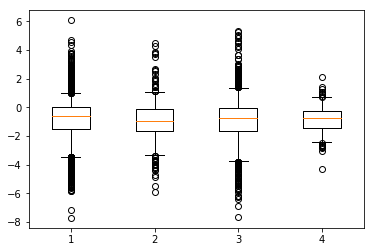

Q_q90


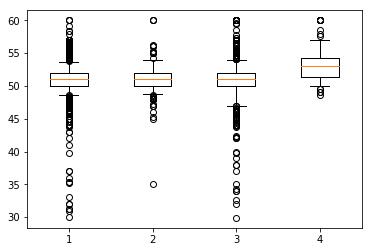

Q_q95


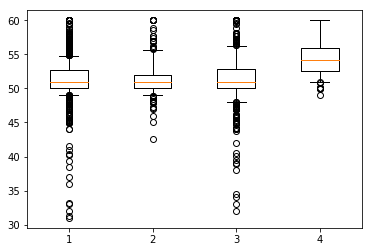

Q_q05


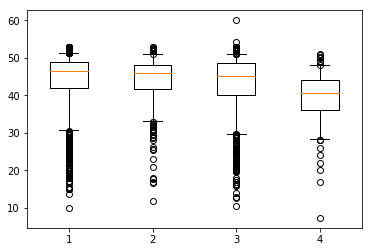

Q_q10


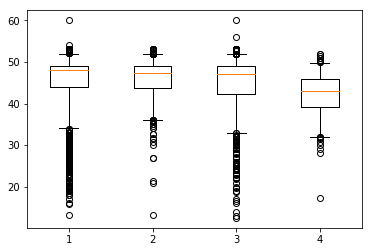

Sv_var


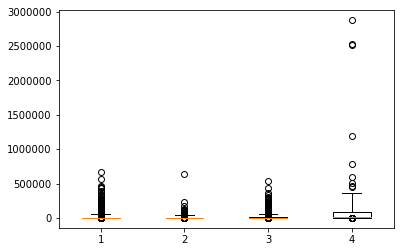

Sv_med


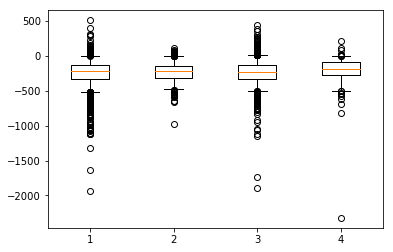

Sv_mean


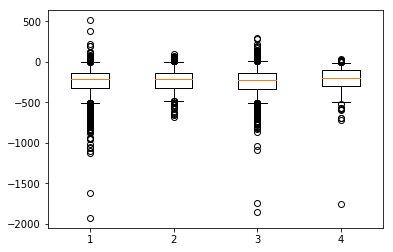

Sv_iqr


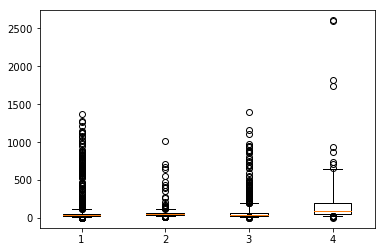

Sv_kurt


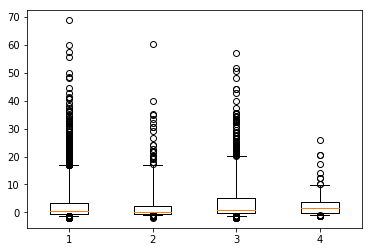

Sv_skew


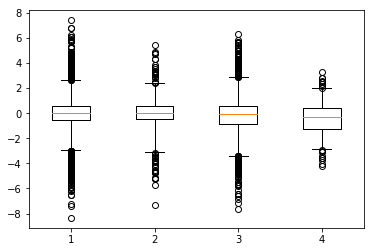

Sv_q90


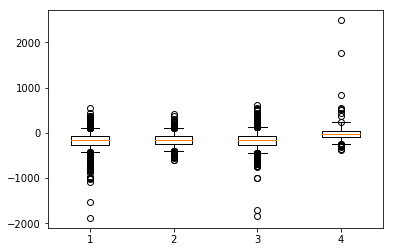

Sv_q95


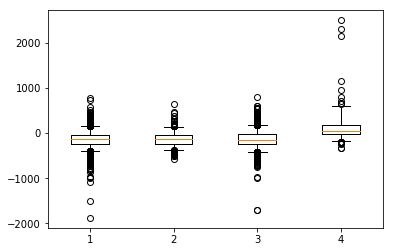

Sv_q05


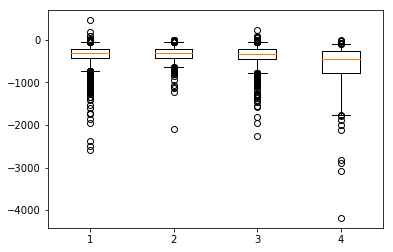

Sv_q10


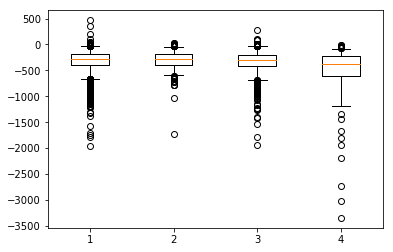

Rv_var


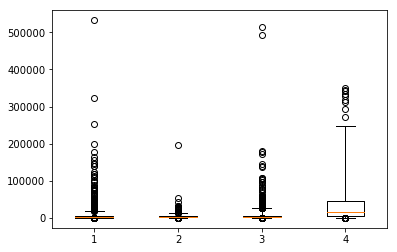

Rv_med


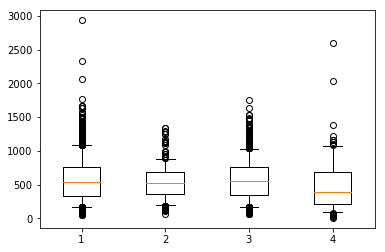

Rv_mean


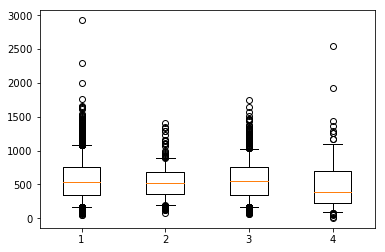

Rv_iqr


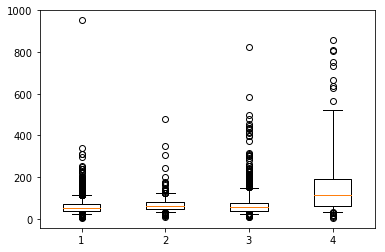

Rv_kurt


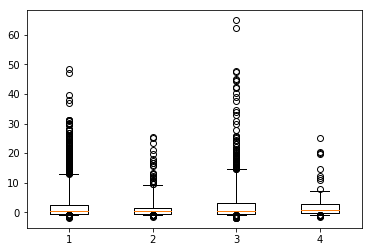

Rv_skew


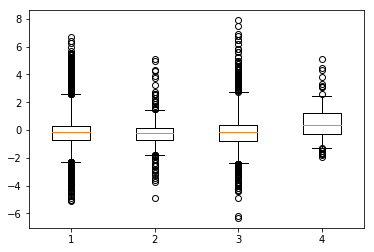

Rv_q90


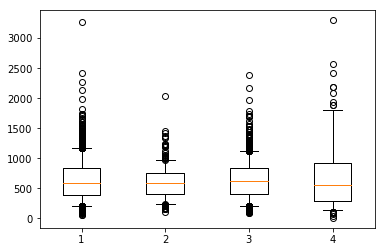

Rv_q95


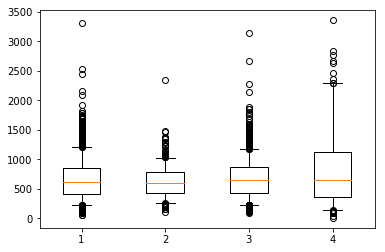

Rv_q05


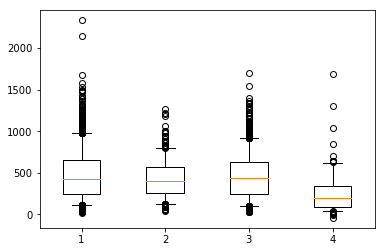

Rv_q10


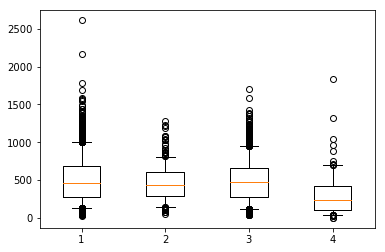

Qv_var


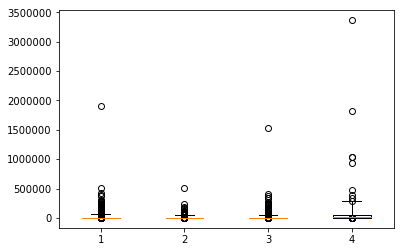

Qv_med


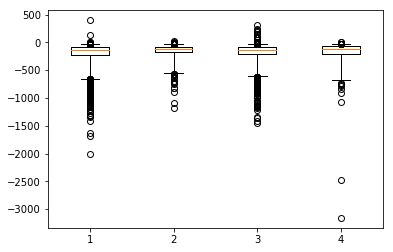

Qv_mean


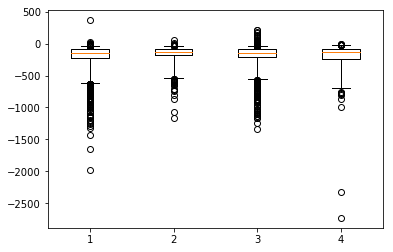

Qv_iqr


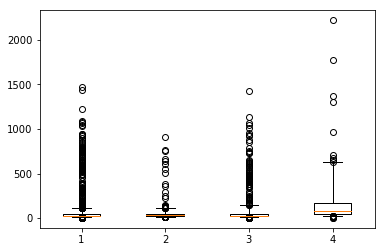

Qv_kurt


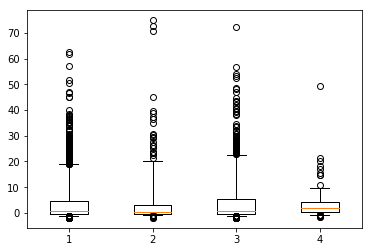

Qv_skew


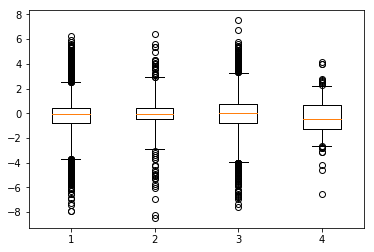

Qv_q90


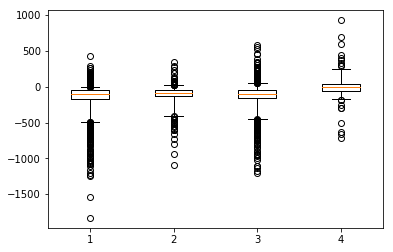

Qv_q95


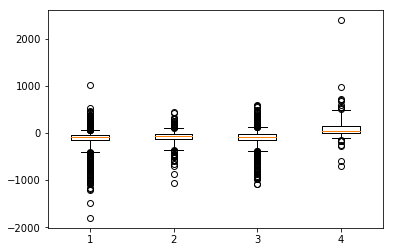

Qv_q05


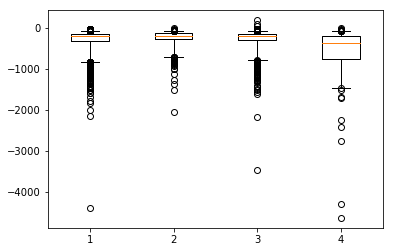

Qv_q10


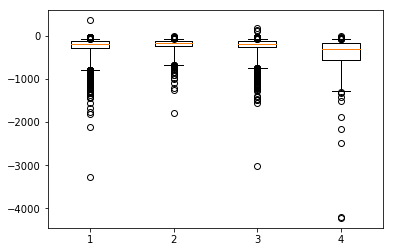

numz_var


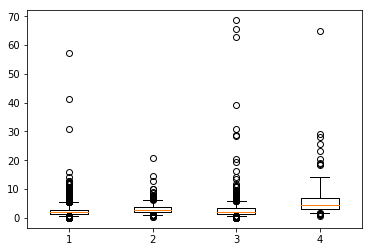

numz_med


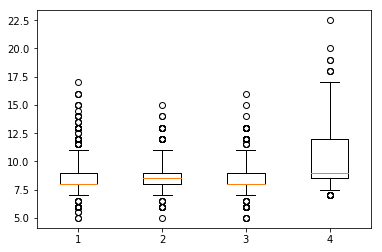

numz_mean


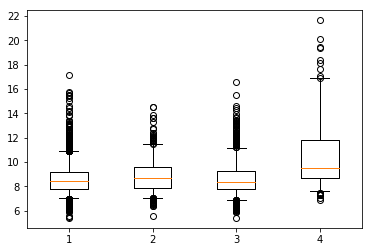

numz_iqr


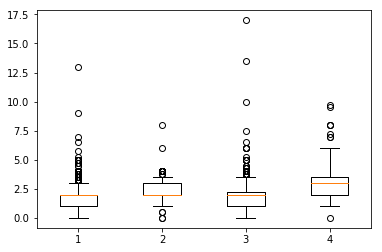

numz_kurt


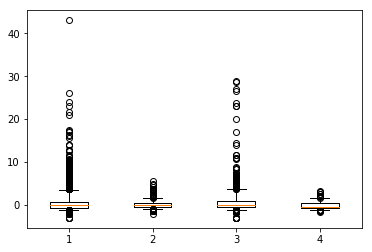

numz_skew


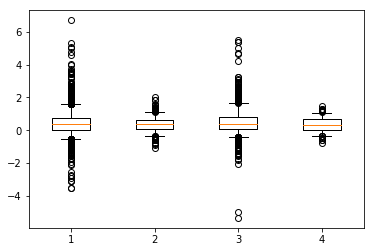

numz_q90


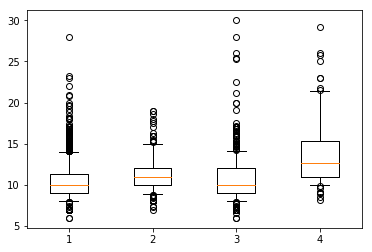

numz_q95


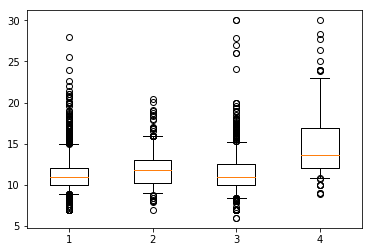

numz_q05


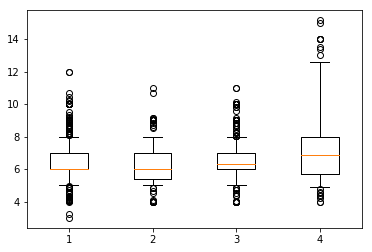

numz_q10


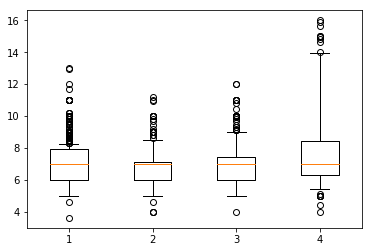

tmprms_var


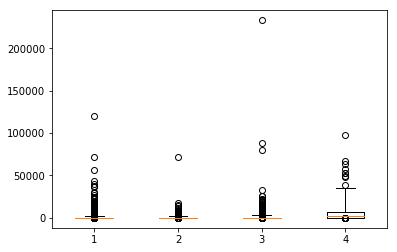

tmprms_med


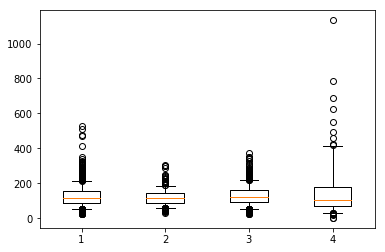

tmprms_mean


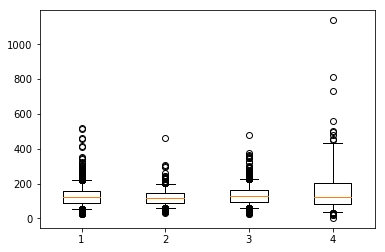

tmprms_iqr


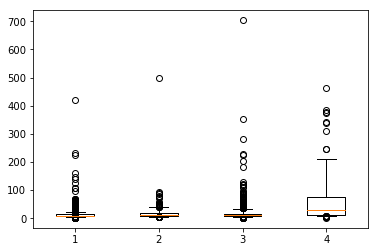

tmprms_kurt


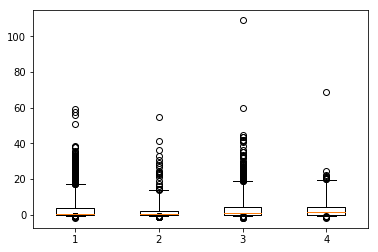

tmprms_skew


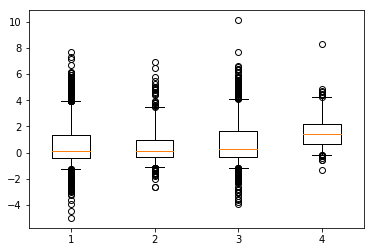

tmprms_q90


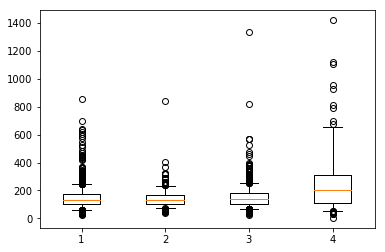

tmprms_q95


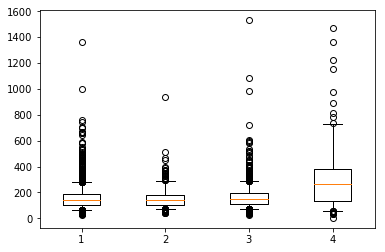

tmprms_q05


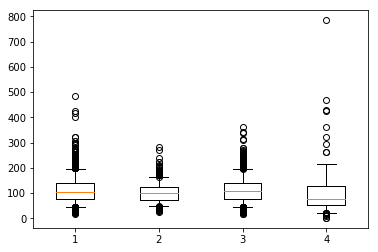

tmprms_q10


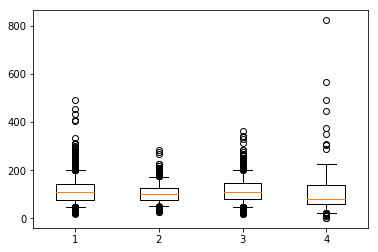

tmpmean_var


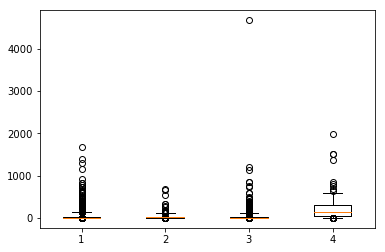

tmpmean_med


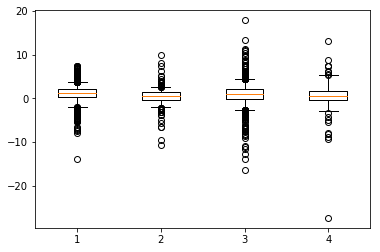

tmpmean_mean


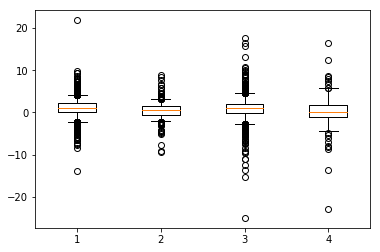

tmpmean_iqr


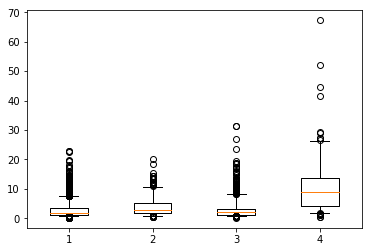

tmpmean_kurt


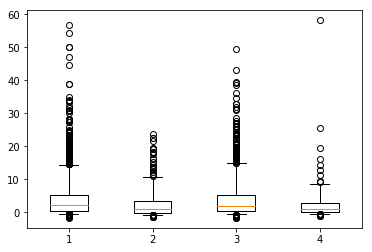

tmpmean_skew


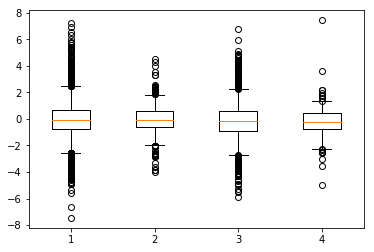

tmpmean_q90


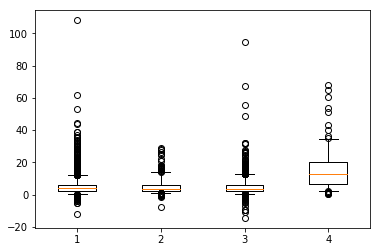

tmpmean_q95


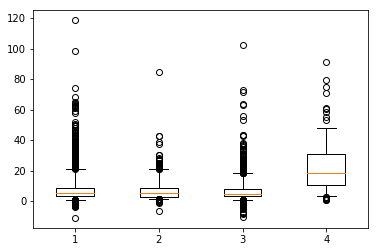

tmpmean_q05


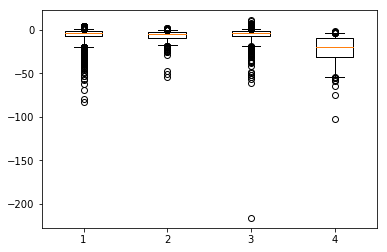

tmpmean_q10


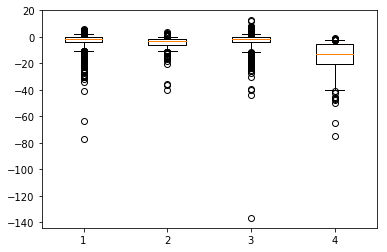

QZ_var


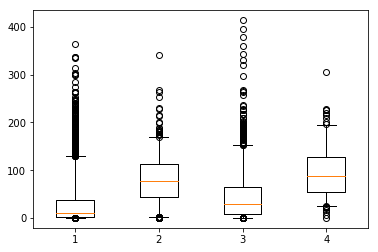

QZ_med


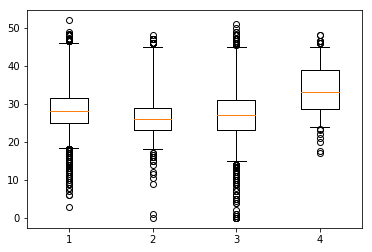

QZ_mean


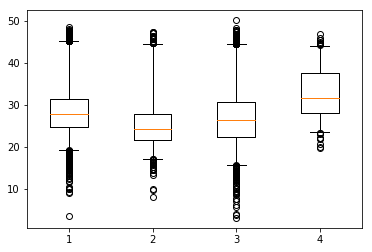

QZ_iqr


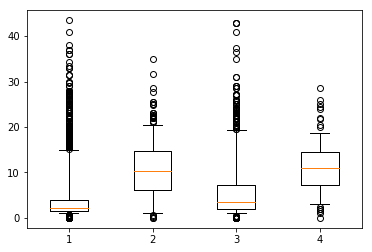

QZ_kurt


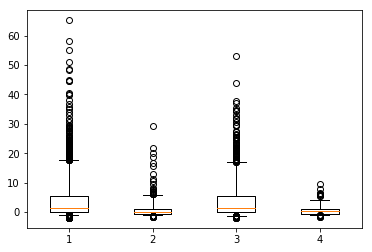

QZ_skew


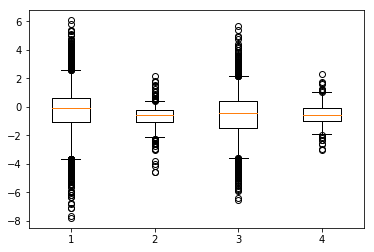

QZ_q90


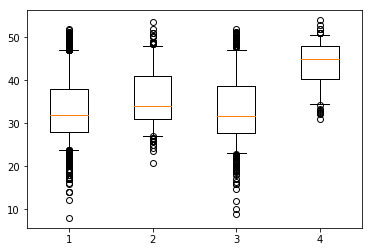

QZ_q95


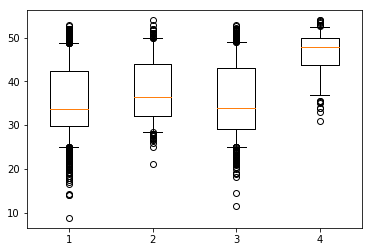

QZ_q05


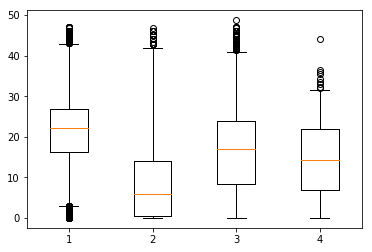

QZ_q10


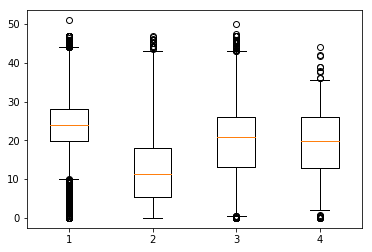

SZ_var


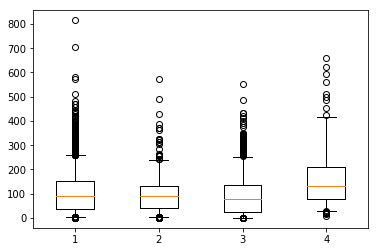

SZ_med


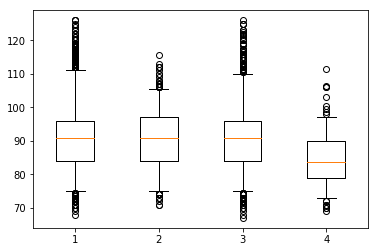

SZ_mean


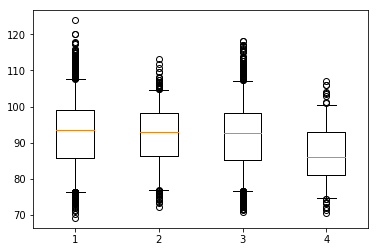

SZ_iqr


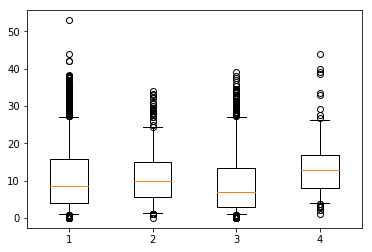

SZ_kurt


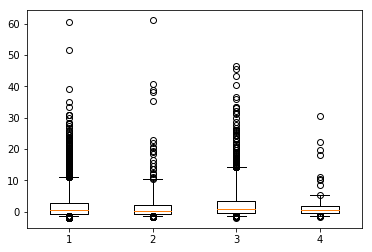

SZ_skew


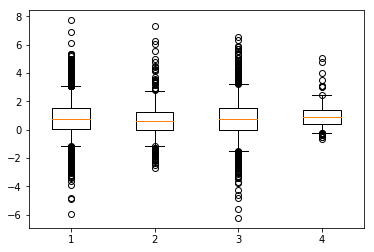

SZ_q90


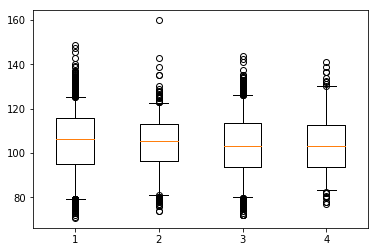

SZ_q95


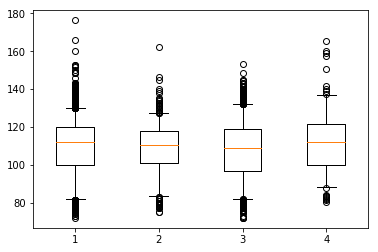

SZ_q05


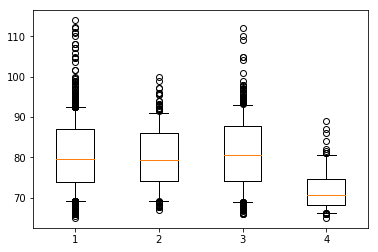

SZ_q10


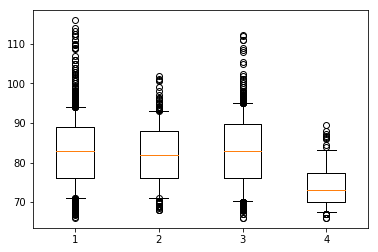

QS_var


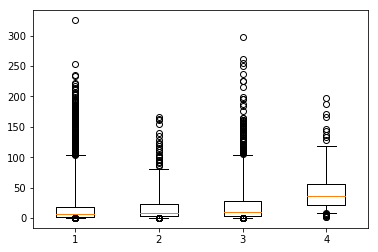

QS_med


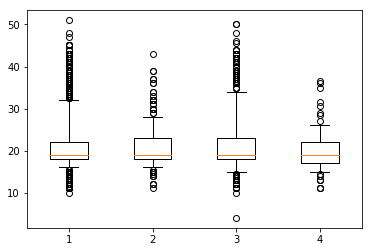

QS_mean


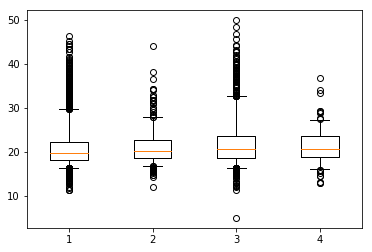

QS_iqr


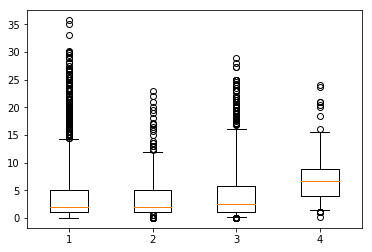

QS_kurt


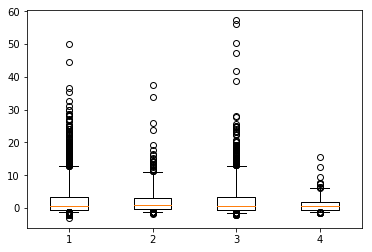

QS_skew


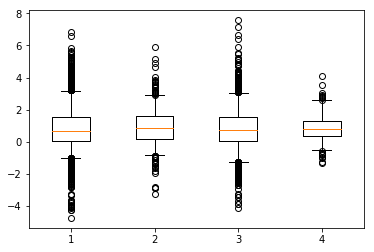

QS_q90


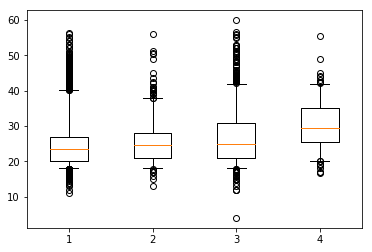

QS_q95


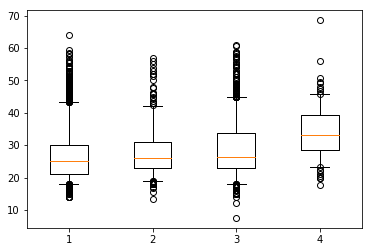

QS_q05


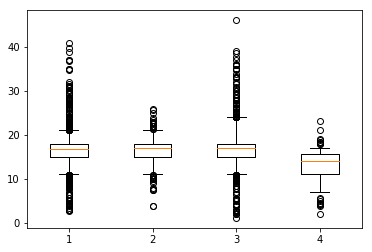

QS_q10


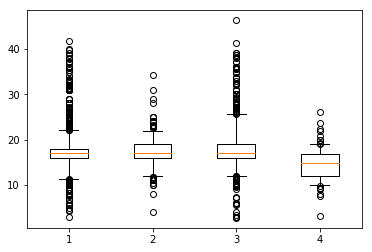

QZSZ_var


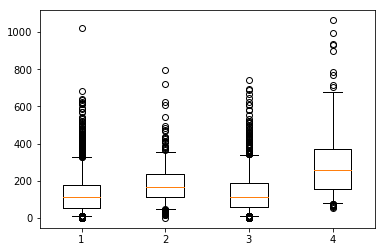

QZSZ_med


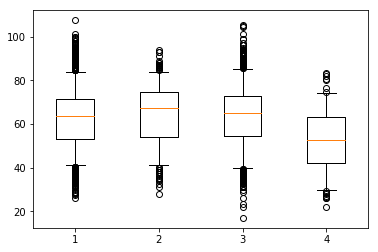

QZSZ_mean


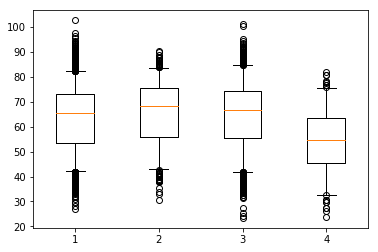

QZSZ_iqr


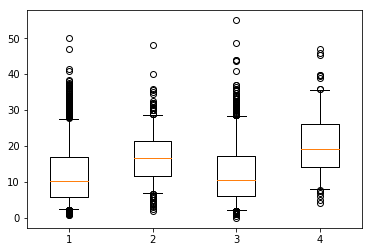

QZSZ_kurt


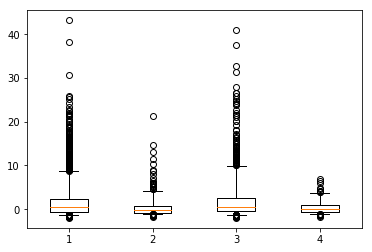

QZSZ_skew


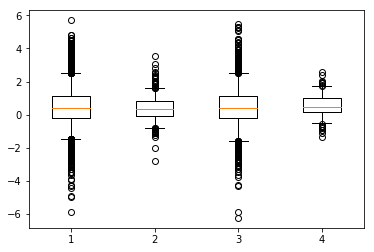

QZSZ_q90


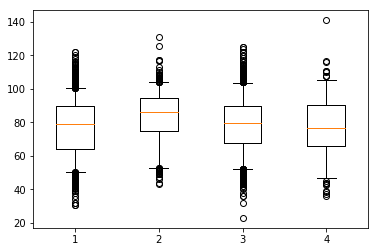

QZSZ_q95


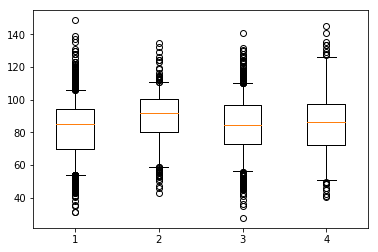

QZSZ_q05


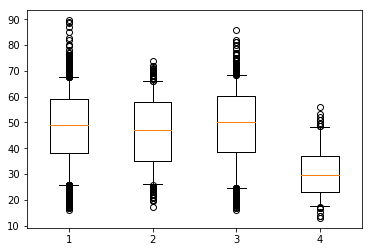

QZSZ_q10


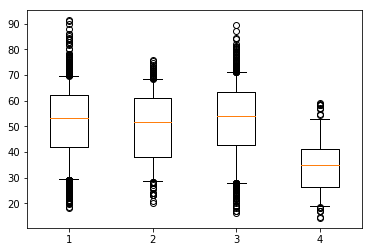

noise_avg


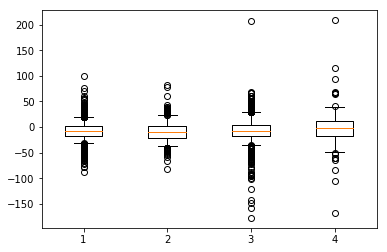

noise_rms


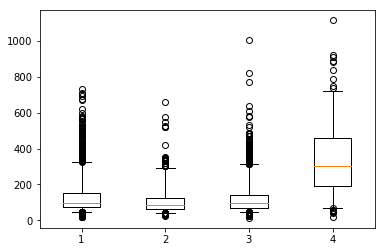

unfiltered_rms


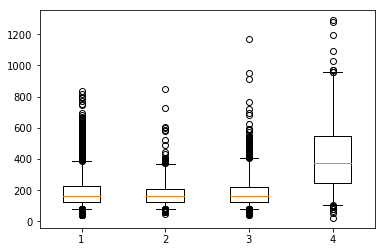

unfiltered_iqr


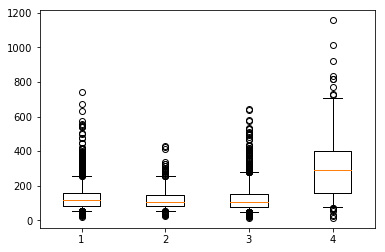

unfiltered_zeros


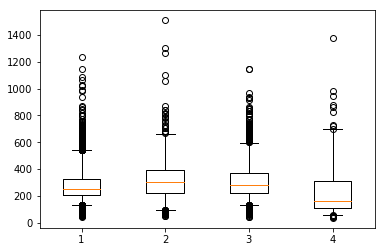

unfiltered_extrema


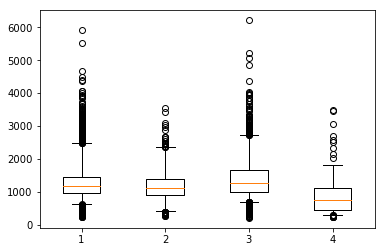

In [40]:
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat)
        box(feat)

# Pre Processing

In [41]:
myfeats = []
for feat in train.columns:
    if feat == 'id' or feat == 'y': continue
    if np.isscalar(train[feat][0]): myfeats.append(feat)
nfeats = len(myfeats)
print(nfeats)

222


In [207]:
X_raw = train[myfeats].values
y_raw = train['y']
print(np.shape(X_raw))

(3411, 222)


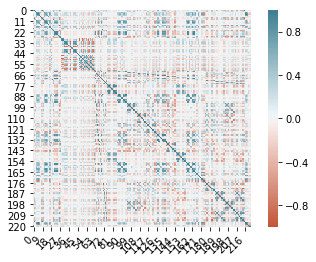

In [43]:
from sklearn.preprocessing import scale
import my_utils
#X_scale = scale(X_raw)
corrcoef = np.corrcoef(X_raw.transpose())
np.shape(corrcoef)
my_utils.corrmap(corrcoef)

In [44]:
sort1d = np.argsort(-abs(corrcoef), axis=None)
pairs = np.array([sort1d//nfeats,sort1d%nfeats]) # 2 rows, n^2 columns

uniquepairs = pairs[:,pairs[0,:]>pairs[1,:]].transpose()

#plt.hist(abs(corrcoef[uniquepairs[:,0],uniquepairs[:,1]]))
#plt.show()

mypairs = uniquepairs[abs(corrcoef[uniquepairs[:,0],uniquepairs[:,1]])>0.9]
for mypair in mypairs:
    #print(mypair)
    print("{: >20} {: >20} {: >20}".format(myfeats[mypair[0]],myfeats[mypair[1]],
          corrcoef[mypair[0],mypair[1]]), end='')
    print('\t',mypair)


         med_tmpmean           tempt_mean                  1.0	 [71 20]
          med_tmprms        tempt_std_dev   0.9999999999999999	 [70 24]
              Rv_med               med_Rv   0.9999999999999998	 [127  67]
      unfiltered_rms   unfiltered_std_dev   0.9999999981370442	 [218   5]
           noise_avg      unfiltered_mean  -0.9999049532838445	 [216   1]
             Rv_mean               med_Rv   0.9967322420879079	 [128  67]
             Rv_mean               Rv_med   0.9967322420879079	 [128 127]
          tmprms_q10           tmprms_q05   0.9965024236039431	 [165 164]
           varex_q10            varex_q05   0.9943882564796338	 [95 94]
              Rv_q10               Rv_q05   0.9882486695165551	 [135 134]
           hr_median              hr_mean   0.9867397204553301	 [31 30]
              Sv_med               med_Sv   0.9847471544439065	 [117  66]
          numex_mean            numex_med   0.9839778216799606	 [78 77]
              Qv_med               med_Qv   0.98

# recursive correlation pruning

In [45]:
tmp_feats = myfeats.copy()

while True:
    ntf = len(tmp_feats)
    print(ntf, end='\t')
    #X_temp = scale(train[tmp_feats].values)
    X_temp = train[tmp_feats].values
    corrcoef = np.corrcoef(X_temp.transpose())
    sort1d = np.argsort(-abs(corrcoef), axis=None)
    pairs = np.array([sort1d//ntf,sort1d%ntf]) # 2 rows, n^2 columns
    uniquepairs = pairs[:,pairs[0,:]>pairs[1,:]].transpose()
    mypair = uniquepairs[0]
    cc = corrcoef[mypair[0],mypair[1]]
    print("{: >15} {: >20} {: >15}".format(tmp_feats[mypair[0]],tmp_feats[mypair[1]],
              cc), end='')
    if abs(cc) > 0.70:
        leaving = tmp_feats[mypair[1]]

        #print('\t',mypair,end='') 
        print('\tremoving ',leaving)
        tmp_feats.remove(leaving)
    else: break

222	    med_tmpmean           tempt_mean             1.0	removing  tempt_mean
221	     med_tmprms        tempt_std_dev 0.9999999999999999	removing  tempt_std_dev
220	         Rv_med               med_Rv 0.9999999999999998	removing  med_Rv
219	 unfiltered_rms   unfiltered_std_dev 0.9999999981370442	removing  unfiltered_std_dev
218	      noise_avg      unfiltered_mean -0.9999049532838445	removing  unfiltered_mean
217	        Rv_mean               Rv_med 0.9967322420879079	removing  Rv_med
216	     tmprms_q10           tmprms_q05 0.9965024236039431	removing  tmprms_q05
215	      varex_q10            varex_q05 0.9943882564796338	removing  varex_q05
214	         Rv_q10               Rv_q05 0.9882486695165551	removing  Rv_q05
213	      hr_median              hr_mean 0.9867397204553301	removing  hr_mean
212	         Sv_med               med_Sv 0.9847471544439065	removing  med_Sv
211	     numex_mean            numex_med 0.9839778216799606	removing  numex_med
210	         Qv_med               m

117	     med_interv               hr_min -0.82093608847566	removing  hr_min
116	          S_q95               S_mean 0.8185609860361628	removing  S_mean
115	     tmprms_q95       std_tempt_mean 0.8087339592052304	removing  std_tempt_mean
114	       QZSZ_iqr               SZ_iqr 0.8068932160269691	removing  SZ_iqr
113	         Qv_var               Sv_var 0.8054978646796891	removing  Sv_var
112	       QZSZ_q95               SZ_q95 0.8049877915891844	removing  SZ_q95
111	       n_tempts                  dur 0.8049859246535794	removing  dur
110	norm_q05_interv          dhr_std_dev -0.8039017505528279	removing  dhr_std_dev
109	         Sv_q10              Sv_mean 0.8003950722959259	removing  Sv_mean
108	     tmprms_q10               Rv_q10 0.7996763387655791	removing  Rv_q10
107	      numex_q10            numex_q95 0.7955699053997629	removing  numex_q95
106	    tmprms_skew           varex_skew 0.7944951079665415	removing  varex_skew
105	        abs_dev   unfiltered_abs_dev 0.792385196544351

after elimination


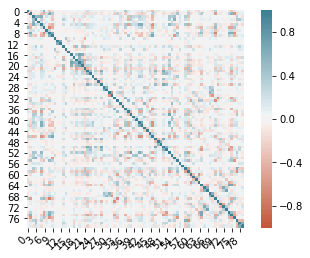

In [46]:
print('after elimination')
my_utils.corrmap(corrcoef)

In [208]:
X_temp_ns = train[tmp_feats].values

In [48]:
#try class 3 vs all
y_rawmix012 = y_raw//3

In [49]:
sum(y_rawmix012==1)

170

In [78]:
from sklearn.model_selection import train_test_split 
X_tr, X_te, y_tr, y_te = train_test_split(X_temp_ns, y_raw, 
                                          test_size=.3, random_state=666
                                          #test_size=0.25
                                         )
n_te = len(y_te)
n_tr = len(y_tr)
print('full :',["%.2f"%(np.sum(y_raw == cl)/n_train) for cl in range(4)])
print('train:',["%.2f"%(np.sum(y_tr == cl)/n_tr) for cl in range(4)])
print('test :',["%.2f"%(np.sum(y_te == cl)/n_te) for cl in range(4)])
np.shape(X_tr)

full : ['0.59', '0.09', '0.29', '0.03']
train: ['0.59', '0.09', '0.29', '0.03']
test : ['0.59', '0.08', '0.29', '0.04']


(3581, 80)

In [79]:
weights = {i:float(n_train)/(np.sum(y_raw == i)) for i in range(4)}
w2 = weights.copy()
w2[0]/=2
w3 = weights.copy()
w3[0]/=4

print(counts)
print(weights)

[3030, 443, 1474, 170]
{0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.4715061058344641, 3: 30.100000000000001}


# Fitting Random Forest ( <3 )

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import GridSearchCV

In [81]:
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = [{'n_estimators': [4000], 
                     'max_depth': [70], 
                   # 'criterion': ['gini',],
                     'min_samples_split': [11,], 
                     'min_samples_leaf': [2], 
                   # 'min_weight_fraction_leaf': [0], 
                   # 'max_features': ['auto'], 
                   # 'max_leaf_nodes': [None],#,100, 300, 500], 
                   # 'min_impurity_decrease': [0], 
                   # 'bootstrap': [True], 
                   # 'oob_score': [False,], 
                   # 'class_weight': [weights]
                    },
                   ]
#scorer = make_scorer(f1_score, average = 'micro')

clf = GridSearchCV(RandomForestClassifier(n_jobs=-1,
                                          class_weight='balanced'
                                         ),
                   tuned_parameters, 
                   cv=5,
                   scoring='f1_micro',
                   n_jobs =-1, 
                   verbose=10,
                   )


clf.fit(X_tr, y_tr)
print('done')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.9s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   51.9s remaining:   34.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.2s finished


done



Plain predictions
test  f1 = 0.805338541667
train f1 = 0.983244903658
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.60      0.92      0.73 1526.6561056105916
           1       0.80      0.71      0.75 1386.0948081264094
           2       0.63      0.62      0.62 1562.1777476254913
           3       0.96      0.63      0.76 1866.199999999998

    accuracy                           0.71 6341.12866136249
   macro avg       0.75      0.72      0.72 6341.12866136249
weighted avg       0.76      0.71      0.72 6341.12866136249


Best parameters set found on development set:
{'max_depth': 70, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 4000}

Normalized confusion matrix
[[ 0.92367257  0.00110619  0.06858407  0.00663717]
 [ 0.05833333  0.70833333  0.225       0.00833333]
 [ 0.30444444  0.05777778  0.6177777

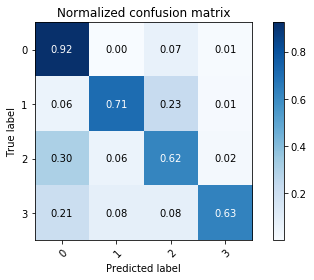

In [82]:
print()

pred_te  = clf.predict(X_te)
print('Plain predictions')
print('test  f1 =', f1_score(y_te, pred_te, average='micro'))
pred_tr = clf.predict(X_tr)
print('train f1 =', f1_score(y_tr, pred_tr, average='micro'))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te, sample_weight = samwe))
print()
print("Best parameters set found on development set:")
print(clf.best_params_)
print()
plot_confusion_matrix(y_te, pred_te, np.array([0,1,2,3]),normalize=True, );

Normalized confusion matrix
[[ 0.92367257  0.00110619  0.06858407  0.00663717]
 [ 0.05833333  0.70833333  0.225       0.00833333]
 [ 0.30444444  0.05777778  0.61777778  0.02      ]
 [ 0.20967742  0.08064516  0.08064516  0.62903226]]
Normalized confusion matrix
[[ 0.9590708   0.00553097  0.03318584  0.00221239]
 [ 0.025       0.85        0.125       0.        ]
 [ 0.28444444  0.08888889  0.62222222  0.00444444]
 [ 0.33870968  0.12903226  0.09677419  0.43548387]]


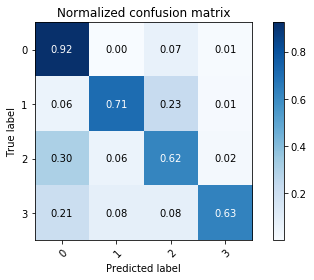

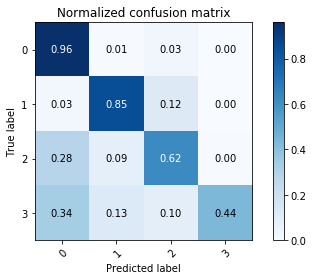

In [113]:
seb666 = clf.best_estimator_.predict_proba(X_te)
sebpred = np.argmax(seb666, axis=1)
sebnorms = np.sum(seb666, axis=1)
plot_confusion_matrix(y_te, sebpred, np.array([0,1,2,3]),normalize=True, );

luc666 = np.load('ensemble15_sum_probas_666.npy')
lucpred = np.argmax(luc666, axis=1)
lucnorms = np.sum(luc666, axis=1)
plot_confusion_matrix(y_te, lucpred, np.array([0,1,2,3]),normalize=True, );

(1536, 8)
(1536,)
Normalized confusion matrix
[[ 0.96460177  0.00442478  0.02876106  0.00221239]
 [ 0.03333333  0.86666667  0.1         0.        ]
 [ 0.28888889  0.08444444  0.62        0.00666667]
 [ 0.33870968  0.11290323  0.08064516  0.46774194]]
test  f1 = 0.8359375


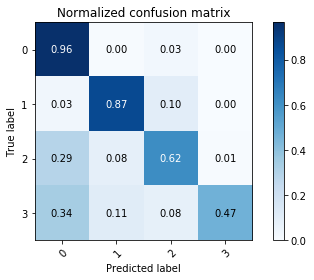

In [115]:
seb = seb666/sebnorms[:,None]
luc = luc666/lucnorms[:,None]
conc = np.hstack([seb,luc])
print(np.shape(conc))
concatpred = np.argmax(conc, axis=1)%4
print(np.shape(concatpred))
plot_confusion_matrix(y_te, concatpred, np.array([0,1,2,3]),normalize=True, );
print('test  f1 =', f1_score(y_te, concatpred, average='micro'))

(1536, 4)
(1536,)
Normalized confusion matrix
[[ 0.96460177  0.00331858  0.02876106  0.00331858]
 [ 0.01666667  0.84166667  0.14166667  0.        ]
 [ 0.28222222  0.06        0.65111111  0.00666667]
 [ 0.30645161  0.06451613  0.09677419  0.53225806]]
test  f1 = 0.845703125


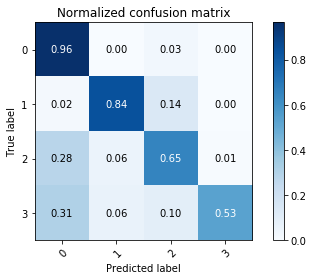

In [176]:
seb = seb666/sebnorms[:,None]
luc = luc666/lucnorms[:,None]
w = [0.6,0.7,0.3,0.9]
vote = seb*w+luc*(np.array([1,1,1,1])-w)
print(np.shape(vote))
votepred = np.argmax(vote, axis=1)%4
print(np.shape(votepred))
plot_confusion_matrix(y_te, votepred, np.array([0,1,2,3]),normalize=True, );
print('test  f1 =', f1_score(y_te, votepred, average='micro'))

In [221]:
y_raw = train_bk['y']


In [222]:
#train_bk
myX = train_bk[tmp_feats].values

rf = RandomForestClassifier(n_estimators = 4000,
                            max_depth=70,
                            min_samples_leaf=2, 
                            class_weight = weights,
                            min_samples_split = 11,
                            n_jobs=-1
                                         )
rf.fit(myX,y_raw)

RandomForestClassifier(bootstrap=True,
                       class_weight={0: 1.6887788778877888,
                                     1: 11.55079006772009,
                                     2: 3.4715061058344641,
                                     3: 30.100000000000001},
                       criterion='gini', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=11, min_weight_fraction_leaf=0.0,
                       n_estimators=4000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [214]:
seb_proba = clf.best_estimator_.predict_proba(X_temp_ns)
luc_proba = np.load('PROBAS_SUM9_TEST.npy')
sebnorms = np.sum(seb_proba, axis=1)
lucnorms = np.sum(luc_proba, axis=1)

seb = aml_proba/sebnorms[:,None]
luc = luc_proba/lucnorms[:,None]
w = [0.5,0.5,0.5,0.5]#[0.6,0.7,0.3,0.9]
vote = seb*w+luc*(np.array([1,1,1,1])-w)
print(np.shape(vote))
votepred = np.argmax(vote, axis=1)%4

#print(np.shape(votepred))
#plot_confusion_matrix(y_te, votepred, np.array([0,1,2,3]),normalize=True, );
#print('test  f1 =', f1_score(y_te, votepred, average='micro'))

(3411, 4)


In [213]:
from datetime import datetime
def prepare_submission(y_graded, comment = ""):
    y_out_template = np.genfromtxt ('sample.csv', delimiter=",")[1:]
    filename = datetime.now().strftime("%m.%d.%H.%M")+"_"+comment+".csv"
    print(filename)
    y_out=y_out_template
    y_out[:,1] = y_graded
    np.savetxt(filename, y_out, delimiter=",",header="id,y",  comments='')
prepare_submission(votepred, 'seb')

12.01.19.41_seb.csv


In [76]:
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


Grid scores on development set:

0.798 (+/-0.030) for {'max_depth': 70, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 4000}


Feature ranking:
#1: norm_q05_interv	importance=0.066891	std=0.066437	<-- low variance
#2: norm_q95_interv	importance=0.061141	std=0.055175	<-- low variance
#3: var_interv	importance=0.053718	std=0.048867	<-- low variance
#4: dhr_abs_dev	importance=0.040338	std=0.040498
#5: iqr_interv	importance=0.040176	std=0.041011
#6: QZ_iqr	importance=0.035284	std=0.041734
#7: tmpmean_q10	importance=0.030402	std=0.043954
#8: med_interv	importance=0.029934	std=0.019250	<-- low variance
#9: unfiltered_iqr	importance=0.028834	std=0.041801
#10: Qv_q95	importance=0.026065	std=0.040538
#11: med_numex	importance=0.025083	std=0.031591
#12: dhr_kurtosis	importance=0.024401	std=0.014758	<-- low variance
#13: QZ_q10	importance=0.023342	std=0.021386	<-- low variance
#14: tmpmean_q95	importance=0.022126	std=0.034518
#15: q95_interv	importance=0.020700	std=0.013329	<-- low variance
#16: unfiltered_zeros	importance=0.016976	std=0.021918
#17: tmprms_iqr	importance=0.016846	std=0.031345
#18: Sv_q95	importance=0.016

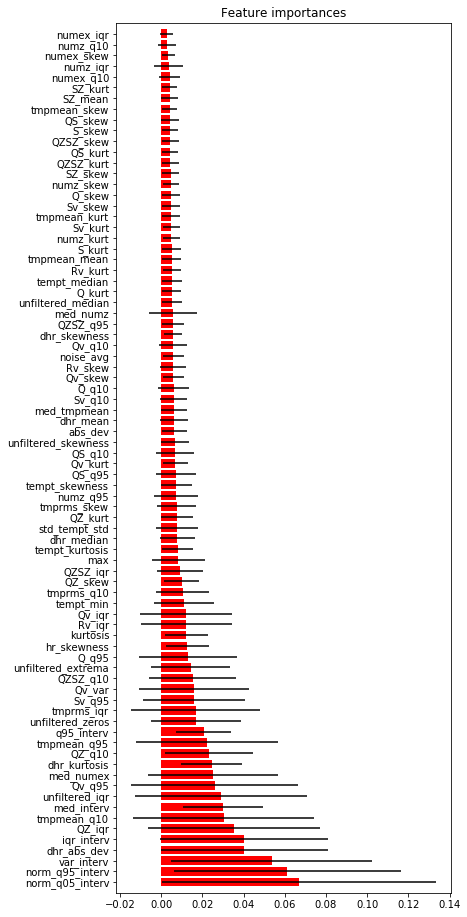

In [56]:
forest = clf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
nfeats = len(indices)
# Print the feature ranking
print("Feature ranking:")
# myfeats is the list of column names we used
pos = 0
for i in indices:
    pos+=1
    print("#%d: %s\timportance=%f\tstd=%f" % 
          (pos, tmp_feats[i], importances[i],std[i]), 
          end = '')
    if  importances[i] > std[i]:
        print('\t<-- low variance')
    else: print()

# Plot the feature importances of the forest
plt.figure(figsize=(6,16))
plt.title("Feature importances")
plt.barh(range(nfeats), importances[indices],
       color="r", xerr=std[indices], align="center")
plt.yticks(range(nfeats), [tmp_feats[i] for i in indices],rotation=0)
plt.ylim([-1,nfeats])
plt.show()

In [57]:
param_names = clf.cv_results_['params'][0].keys()
param_mx = {pname: [str(params[pname]) for params in clf.cv_results_['params']] for pname in param_names}

# RFECV - useless in theory .

In [ ]:
raise

In [58]:
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
estimator = RandomForestClassifier(n_estimators = 3000, min_samples_leaf=2, 
                                   class_weight = weights,
                                   n_jobs=-1)

selector = RFECV(estimator, verbose=10, n_jobs=-1,
                 scoring='f1_micro',
                 step=1, 
                 min_features_to_select=10,
                )

selector = selector.fit(X_raw, y_raw, )

print(selector.support_)
print(selector.ranking_)

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

# Prediction

In [ ]:
if not predicting: raise

In [ ]:
#retrain the model with all the data and best params from cv
{'bootstrap': True, 
 'criterion': 'gini', 
 'max_depth': None, 
 'max_features': 'auto', 
 'max_leaf_nodes': None, 
 'min_impurity_decrease': 0, 
 'min_samples_leaf': 2, 
 'min_samples_split': 2, 
 'min_weight_fraction_leaf': 0, 
 'n_estimators': 3000, 
 'oob_score': False}

rf = RandomForestClassifier(n_estimators = 3000, min_samples_leaf=2, class_weight = weights,
                                          n_jobs=-1
                                         )
rf.fit(X_raw,y_raw)

In [ ]:
rf_tr = rf.predict(X_raw)
print('train f1 =', f1_score(y_raw, rf_tr, average='micro'))

### Careful
This was not quite thought out... If you want to predict for the test set you have to got to the top of the notebook and replace the `train` dataframe with the `test` dataframe, rerun all the pre processing and feature extraction, and make sure NOT to erase the trained model. Just run predict after normalising

In [ ]:
rf_AML = rf.predict(X_raw)

In [ ]:
from datetime import datetime
def prepare_submission(y_graded, comment = ""):
    y_out_template = np.genfromtxt ('sample.csv', delimiter=",")[1:]
    filename = datetime.now().strftime("%m.%d.%H.%M")+"_"+comment+".csv"
    print(filename)
    y_out=y_out_template
    y_out[:,1] = y_graded
    np.savetxt(filename, y_out, delimiter=",",header="id,y",  comments='')

In [ ]:
prepare_submission(rf_AML, 'seb')

# More feature ideas...

In [ ]:
raise # to prevent automatic execution beyond this cell ...

In [ ]:
n = 10
rows = subsets()[0].sample(n)#.iloc[0]
for id,row in rows.iterrows():
    #print(row.y)
    freqs, power = welch_spectrum(row.X, sampling_rate=freq,size=180)
    plt.plot(freqs,power,c='red')
rows = subsets()[3].sample(n)#.iloc[0]
for id,row in rows.iterrows():
    #print(row.y)
    freqs, power = welch_spectrum(row.X, sampling_rate=freq,size=180)
    plt.plot(freqs,power,c='blue')
plt.show()


In [ ]:
plt.boxplot([sub['hr_std_dev'] for sub in subsets()])
plt.show()

In [ ]:
sample = subsets()[3].sample(1).iloc[0]
ref = subsets()[0].loc[537]

print(sample.id, ": ",sample.y)
print(ref.id, ": ",ref.y, '(ref)')

#plt.plot(sample.ts, sample.X)
plt.plot(sample.ts, sample.filtered, label=str(sample.y))
#plt.plot(templates_ts+sample.rpeaks[1]/freq, sample.templates[1])
#plt.show()

plt.plot(ref.ts, ref.filtered, label=str(ref.y))
#plt.plot(templates_ts+ref.rpeaks[1]/freq, ref.templates[1])

#plt.xlim([9,12])
plt.legend()
plt.show()

plt.plot(sample.heart_rate_ts-1, sample.heart_rate, label=str(sample.y))
plt.plot(   ref.heart_rate_ts*1.3333,    ref.heart_rate, label=str(   ref.y))
plt.plot( sample.heart_rate, label=str(sample.y))
plt.plot( ref.heart_rate, label=str(   ref.y))

plt.legend()
plt.show()



#plt.show()
for template in ref.templates:
    plt.plot(templates_ts, template,c='black')
#plt.plot(templates_ts, ref.avg_tempt, c='black')
for template in sample.templates:
    plt.plot(templates_ts, template)
plt.show()

In [ ]:
ids = [2312, 3606]
plt.boxplot(train.intervs.loc[ids])
plt.xticks(range(1+len(ids)), train.id.loc[ids])
plt.show()
plt.boxplot(train.heart_rate.loc[ids])
plt.show()

In [ ]:
train.loc[2312].var_interv

In [ ]:
train.loc[3606].var_interv

In [ ]:
subset = train
for id, sample in subset.sample(10).iterrows():
    print(id,':',sample.y)
    plt.plot(sample.intervs, label='filt')
    plt.ylim([50,500])
    #plt.plot(sample.ecg['ts'], sample.X, label='raw')
    #plt.plot(sample['templates_ts'], sample['templates'], label='template')
    plt.legend()
    plt.show()
    #plt.boxplot([sub['var_interv'] for sub in subsets])
plt.show()

In [ ]:
plt.boxplot([np.var(hrts) for sub in subsets for hrts in sub.heart_rate_ts])
plt.show()

In [ ]:
for subset in subsets():
    sample = subset.sample(1).iloc[0]
    print("id:",sample.id, '\tclass:', sample.y)
    plt.hist(sample.intervs,20, label=str(sample.y))
plt.legend()
plt.show()

In [ ]:
i=0
for subset in subsets()[0:1]:#, train2, train3]:
    plt.scatter(subset.y, subset.var_interv, label=i, s=1)
    plt.ylim([0,50000])
    i+=1
    plt.legend()
plt.show()

In [ ]:
[sample.var_interv for _, sample in train.loc[ids].iterrows()]

In [ ]:
ids =  []
for subset in subsets():
    for k in subset.sample(1).index.values:
        ids.append(k)
        sample = subset.loc[k]
        print("id:",k, 'class:', sample.y,'length:', len(sample.rpeaks))
        #for template in sample.ecg['templates'][5:-5]:
        #    plt.plot(template)
        #plt.show()
        plt.plot(sample.avg_tempt)
        plt.plot(sample.max_tempt)
        plt.plot(sample.min_tempt)
        plt.show()

#plt.legend()
#plt.show()

plt.boxplot(train.intervs[ids])
plt.show()

# CODE DUMPSTER:

# Fitting SVC - bad IDEA, waste of time!

In [ ]:
if predicting: raise

In [ ]:
from sklearn.svm import SVC

tuned_parameters = [
                    #{'kernel': ['rbf'], 
                    # 'gamma' : [ 1e-2, 1e-1, 1e-0],
                    # 'C'     : [0.1,0.9,1,1.1,1000],
                    #},
                    {'kernel': ['poly'], 
                     'gamma' : [9e-3, 1e-2, 1.1e-2],
                     'degree': [4],  
                     'C'     : [0.15,0.2,0.3,0.4],
                     'coef0' : [1],
                    },
                   ]

# set probability to true if you want to get confidence estimates later
# (makes fitting slower)
gs_svc = GridSearchCV(SVC(class_weight = weights, probability=False),
                   tuned_parameters, 
                   cv = 5,
                   scoring='f1_micro',
                   n_jobs=-1, verbose=15)


gs_svc.fit(X_tr, y_tr)


print()
print("Grid scores on development set:")
print()
means = gs_svc.cv_results_['mean_test_score']
stds = gs_svc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_svc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


In [ ]:
print()

svc_pred_te  = gs_svc.predict(X_te)
print('Plain predictions')
print('test  f1 =', f1_score(y_te, svc_pred_te, average='micro'))
svc_pred_tr = gs_svc.predict(X_tr)
print('train f1 =', f1_score(y_tr, svc_pred_tr, average='micro'))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, svc_pred_te, sample_weight = samwe))
print()
print("Best parameters set found on development set:")
print()
print(gs_svc.best_params_)

In [ ]:
param_names = gs_svc.cv_results_['params'][0].keys()
param_mx = {pname: 
                [str(params[pname]) for params in gs_svc.cv_results_['params']]
            for pname in param_names}

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 7)

plt.scatter(param_mx['min_impurity_decrease'], means)
plt.show()


In [ ]:
forest = gs_svc.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
nfeats = len(indices)
# Print the feature ranking
print("Feature ranking:")
# myfeats is the list of column names we used
pos = 0
for i in indices:
    pos+=1
    print("#%d: %s\timportance=%f\tstd=%f" % 
          (pos, myfeats[i], importances[i],std[i]), 
          end = '')
    if  importances[i] > std[i]:
        print('\t<-- low variance')
    else: print()

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(nfeats), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(nfeats), indices)
plt.xlim([-1,nfeats])
plt.show()

## PCA ?
could be done on train+test since it's unsupervised

In [ ]:
from sklearn.decomposition import PCA
    
if not predicting:
    pca = PCA(n_components=40)
    pca.fit(X_raw)
    print('least important 5:',pca.explained_variance_ratio_[-5:])
    print('explained variance:',sum(pca.explained_variance_ratio_))

X_pca = pca.transform(X_raw)

In [ ]:
i=0
for comp in pca.components_:
    i+=1
    indeces = comp.argsort()[-5:][::-1]
    print('c%d='%i,[myfeats[i] for i in indeces])

## Fitting MLP: (too slow, fuck this)

In [ ]:
if predicting: raise

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import GridSearchCV

In [ ]:
myw1 = weights.copy()
myw2 = weights.copy()

myw1[0]*=1
myw1[1]*=2
myw1[2]*=2
myw1[3]*=2

myw2[0]*=1
myw2[1]*=1
myw2[2]*=1
myw2[3]*=0.5
print(myw1)
print(myw2)
#tweaking the weights made no difference, we need more features 
# to improve accuracy on 0 and 2

In [ ]:
from sklearn.neural_network import MLPClassifier
tuned_parameters = [{'alpha': [1e-6],
                     'hidden_layer_sizes': [(30,20,10,10),],
                     'activation': ['relu'],
                     #'class_weight': [weights],
                     'learning_rate':['invscaling'],
                     'batch_size': ['auto']
                    },
                   ]
#scorer = make_scorer(f1_score, average = 'micro')

gs_mlp = GridSearchCV(MLPClassifier(solver='sgd',
                                    max_iter=2000,
                                    tol=1e-4,
                                    verbose = False,
                                    n_iter_no_change=10,
                                    
                                    ),
                   tuned_parameters, 
                   cv=5,
                   scoring='f1_micro',
                   n_jobs =-1, 
                   verbose=10,
                   )


gs_mlp.fit(X_tr, y_tr)
print('done.')


In [ ]:
print()

pred_te  = gs_mlp.predict(X_te)
print('Plain predictions')
print('test  f1 =', f1_score(y_te, pred_te, average='micro'))
pred_tr = gs_mlp.predict(X_tr)
print('train f1 =', f1_score(y_tr, pred_tr, average='micro'))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te, sample_weight = samwe))
print()
print("Best parameters set found on development set:")
print(gs_mlp.best_params_)
print()
plot_confusion_matrix(y_te, pred_te, np.array([0,1,2,3]),normalize=True, );

In [ ]:

print()
print("Grid scores on development set:")
print()
means = gs_mlp.cv_results_['mean_test_score']
stds = gs_mlp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_mlp.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

## old plots

In [ ]:
dhr = [np.diff(hr) for hr in train.heart_rate_ts]
plt.plot(dhr[456])

In [ ]:
#row = randrow(0)
#print(row.id,'y:',row.y)
#print('ntemps', row.n_tempts)
gfs=[get_g_feats(randrow(i).templates) for i in range(4)]
for feat in gfs[0]:
    print(feat)
    plt.boxplot([gf[feat] for gf in gfs])
    plt.show()

In [ ]:
row = randrow(-1)
#signal = row.avg_tempt[:3000]
signal = row.avg_tempt[:3000]
print(row.id,'y:',row.y)
extrema, values = find_extrema(signal)
plt.plot(extrema, values)
plt.plot(signal)
#R_peaks, S_point, Q_point = EKG_QRS_detect(signal, freq, True, True)
#print(S_point-Q_point)
R = np.array([60]) # R is always at sample 60 within the template
S = find_S_point(signal, R)[0]
Q = find_Q_point(signal, R)[0]
R=R[0]
S_val = signal[S]
R_val = signal[R]
Q_val = signal[Q]
plt.scatter([Q,R,S],[Q_val,R_val,S_val])
print(S-Q)
print(len(extrema))
zeros = zero_cross(signal)['zeros']
QZ = np.max(zeros[zeros<Q])
SZ = np.min(zeros[zeros>S])
plt.axvline(x=QZ)
plt.axvline(x=SZ)